In [86]:
#!pip install catboost

In [1]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
print(f"catBoost version: {cb.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")

catBoost version: 1.2.2
numpy version: 1.26.0
pandas version: 2.1.1
seaborn version: 0.12.2


In [3]:
print('Loading Properties ...')
properties2016 = pd.read_csv('properties_2016.csv', low_memory = False)
properties2017 = pd.read_csv('properties_2017.csv', low_memory = False)

print('Loading Train ...')
train2016 = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train2017 = pd.read_csv('train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

print('Loading Sample ...')
sample_submission = pd.read_csv('sample_submission.csv', low_memory = False)

print('Done ...')

Loading Properties ...
Loading Train ...
Loading Sample ...
Done ...


In [4]:
print(properties2016.shape)
print(properties2017.shape)
print(train2016.shape)
print(train2017.shape)
print(sample_submission.shape)

(2985217, 58)
(2985217, 58)
(90275, 3)
(77613, 3)
(2985217, 7)


## Exploring the csvs

In [5]:
train2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,1/1/2016
1,14366692,-0.1684,1/1/2016
2,12098116,-0.0040,1/1/2016
3,12643413,0.0218,2/1/2016
4,14432541,-0.0050,2/1/2016


In [6]:
train2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,1/1/2017
1,17052889,0.055619,1/1/2017
2,14186244,0.005383,1/1/2017
3,12177905,-0.103410,1/1/2017
4,10887214,0.006940,1/1/2017


In [7]:
properties2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [8]:
properties2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [9]:
sample_submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


## Observing sample submission parcelID order

In [10]:
sample_submission["ParcelId"].equals(properties2016["parcelid"])

True

In [11]:
sample_submission["ParcelId"].equals(properties2017["parcelid"])

False

The parcelid order in sample submission seems to follow that of 2016, thus we need to reorder 2017

### Reordering properties2017

In [12]:
properties2017 = pd.merge(sample_submission["ParcelId"], properties2017, how='left', left_on ='ParcelId',right_on='parcelid').drop("ParcelId", axis=1)
properties2017

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,110245.0,226900.0,2016.0,116655.0,3035.26,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,3.0,3.0,NaN,NaN,3.0,NaN,...,NaN,NaN,378466.0,762157.0,2016.0,383691.0,8653.10,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,NaN,NaN,201575.0,483188.0,2016.0,281613.0,5671.40,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,NaN,...,NaN,NaN,347863.0,578621.0,2016.0,230758.0,5894.36,NaN,NaN,NaN


In [13]:
sample_submission["ParcelId"].equals(properties2017["parcelid"])

True

## Splitting transaction dates into month, year (removing day)

In [14]:
def split_date(df):
    df["transactiondate"] = pd.to_datetime(df["transactiondate"], dayfirst=True)
    df["transaction_year"] = df["transactiondate"].dt.year
    
#     df["transaction_month"] = df["transactiondate"].dt.month

#     the code below is used if we want to let 2017 jan start as month 13 (might be useful when we combine both years to train a model)
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month

    
#     df["transaction_day"] = df["transactiondate"].dt.day
    
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

train2016 = split_date(train2016)
train2017 = split_date(train2017)

In [15]:
print(train2016.shape)
train2016.head()

(90275, 4)


,parcelid,logerror,transaction_year,transaction_month
0,11016594,0.0276,2016,1
1,14366692,-0.1684,2016,1
2,12098116,-0.0040,2016,1
3,12643413,0.0218,2016,1
4,14432541,-0.0050,2016,1


In [16]:
print(train2017.shape)
train2017.head()

(77613, 4)


,parcelid,logerror,transaction_year,transaction_month
0,14297519,0.025595,2017,13
1,17052889,0.055619,2017,13
2,14186244,0.005383,2017,13
3,12177905,-0.103410,2017,13
4,10887214,0.006940,2017,13


we can see that Jan 2017 starts as month 13

## Non-Null counts for the columns in properties.csv

In [17]:
properties2016.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   parcelid                      2985217 non-null  int64  
 1   airconditioningtypeid         811519 non-null   float64
 2   architecturalstyletypeid      6061 non-null     float64
 3   basementsqft                  1628 non-null     float64
 4   bathroomcnt                   2973755 non-null  float64
 5   bedroomcnt                    2973767 non-null  float64
 6   buildingclasstypeid           12629 non-null    float64
 7   buildingqualitytypeid         1938488 non-null  float64
 8   calculatedbathnbr             2856305 non-null  float64
 9   decktypeid                    17096 non-null    float64
 10  finishedfloor1squarefeet      202717 non-null   float64
 11  calculatedfinishedsquarefeet  2929652 non-null  float64
 12  finishedsquarefeet12        

## Possible cleaning of dataframe  

 ### 1) remove the features with 1 unique value 

In [18]:
oneUniqueValueList2016 = []

for i in properties2016.columns:
    uniqueNum = properties2016[i].nunique()
    
    if uniqueNum == 1:
        oneUniqueValueList2016.append(i)
    
    
oneUniqueValueList2016

['decktypeid',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

In [19]:
oneUniqueValueList2017 = []

for i in properties2017.columns:
    uniqueNum = properties2017[i].nunique()
    
    if uniqueNum == 1:
        oneUniqueValueList2017.append(i)
    
    
oneUniqueValueList2017

['decktypeid',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

Both 2016 and 2017 have the same columns that only has 1 unique value, thus we will be removing them

### Removing above elements from our df

In [20]:
properties2016.drop(oneUniqueValueList2016, inplace = True, axis=1)
properties2017.drop(oneUniqueValueList2017, inplace = True, axis=1)

print(properties2016.shape)
print(properties2017.shape)

(2985217, 49)
(2985217, 49)


## Labelling our numerical & categorical columns

In [21]:
nominal_features = ["censustractandblock",
                    "airconditioningtypeid",
                    "architecturalstyletypeid",
                    "buildingclasstypeid",
                    "fips",
                    "heatingorsystemtypeid",
                    "propertycountylandusecode",
                    "propertylandusetypeid",
                    "regionidcounty",
                    "typeconstructiontypeid",
                    "rawcensustractandblock",
                    "regionidneighborhood",
                    "propertyzoningdesc",
                    "regionidcity",
                    "regionidzip",                  
                   ]

ordinal_features = ["bathroomcnt",
                    "bedroomcnt",
                    "buildingqualitytypeid",
                    "calculatedbathnbr",
                    "threequarterbathnbr",
                    "fireplacecnt",
                    "fullbathcnt",
                    "garagecarcnt",
                    "numberofstories",
                    "roomcnt",
                    "unitcnt",
                    "taxdelinquencyyear",
                    "yearbuilt",
                    "assessmentyear"] 

categorical_features = nominal_features + ordinal_features

#we have to include the transaction date individual features that we created
categorical_features += ["transaction_year", "transaction_month"]

numeric_features = ["basementsqft",
                    "finishedfloor1squarefeet",
                    "calculatedfinishedsquarefeet",
                    "finishedsquarefeet6",
                    "finishedsquarefeet12",
                    "finishedsquarefeet13",
                    "finishedsquarefeet15",
                    "finishedsquarefeet50",
                    "garagetotalsqft",
                    "latitude",
                    "longitude",
                    "lotsizesquarefeet",
                    "poolsizesum",
                    "yardbuildingsqft17",
                    "yardbuildingsqft26",
                    "taxvaluedollarcnt",
                    "structuretaxvaluedollarcnt",
                    "landtaxvaluedollarcnt",
                    "taxamount"]

In [22]:
print(f"numeric features length: {len(numeric_features)}")
print(f"categorical features length: {len(categorical_features)}")

numeric features length: 19
categorical features length: 31


## Preparing our train and test data

- our first approach is to combine both 2016 and 2017 data and train a model that predicts both years together
- we have to merge train.csv with their respective properties.csv


In [23]:
# how = left is equivalent to a left join in SQL, thus we will only have a dataframe with houses that are sold
combined2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')  
combined2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')

print(combined2016.shape)
print(combined2017.shape)

(90275, 52)
(77613, 52)


In [24]:
#we can see the merging of both train and properties
combined2016.head()

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,6.037107e+13
1,14366692,-0.1684,2016,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN
2,12098116,-0.0040,2016,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,6.037464e+13
3,12643413,0.0218,2016,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,6.037296e+13
4,14432541,-0.0050,2016,1,NaN,NaN,NaN,2.5,4.0,NaN,...,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,6.059042e+13


In [25]:
# combining 2016 and 2017 for the final df
combined = pd.concat([combined2016, combined2017])
combined

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,6.037107e+13
1,14366692,-0.168400,2016,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN
2,12098116,-0.004000,2016,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,6.037464e+13
3,12643413,0.021800,2016,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,6.037296e+13
4,14432541,-0.005000,2016,1,NaN,NaN,NaN,2.5,4.0,NaN,...,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017,21,1.0,NaN,NaN,3.0,3.0,NaN,...,NaN,1980.0,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,6.037132e+13
77609,11000655,0.020615,2017,21,NaN,NaN,NaN,2.0,2.0,NaN,...,NaN,1940.0,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,6.037101e+13
77610,17239384,0.013209,2017,21,NaN,NaN,NaN,2.0,4.0,NaN,...,NaN,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,6.111008e+13
77611,12773139,0.037129,2017,21,1.0,NaN,NaN,1.0,3.0,NaN,...,NaN,1954.0,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,6.037434e+13


## Populating NaN values (0 for numerical columns, empty string for categorical columns)

In [26]:
combined[numeric_features] = combined[numeric_features].fillna(0)

In [27]:
combined[categorical_features] = combined[categorical_features].fillna('')

## Converting all categorical feature values to strings (a requirement for catBoost)

In [28]:
for i in categorical_features:
    combined[i] = combined[i].astype(str)

In [29]:
combined

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016,1,1.0,,0.0,2.0,3.0,,...,0.0,1959.0,,122754.0,360170.0,2015.0,237416.0,6735.88,,60371066461001.0
1,14366692,-0.168400,2016,1,,,0.0,3.5,4.0,,...,0.0,2014.0,,346458.0,585529.0,2015.0,239071.0,10153.02,,
2,12098116,-0.004000,2016,1,1.0,,0.0,3.0,2.0,,...,0.0,1940.0,,61994.0,119906.0,2015.0,57912.0,11484.48,,60374638003004.0
3,12643413,0.021800,2016,1,1.0,,0.0,2.0,2.0,,...,0.0,1987.0,,171518.0,244880.0,2015.0,73362.0,3048.74,,60372963002002.0
4,14432541,-0.005000,2016,1,,,0.0,2.5,4.0,,...,0.0,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,,60590423381006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017,21,1.0,,0.0,3.0,3.0,,...,0.0,1980.0,,265000.0,379000.0,2016.0,114000.0,4685.34,,60371319001006.0
77609,11000655,0.020615,2017,21,,,0.0,2.0,2.0,,...,0.0,1940.0,,70917.0,354621.0,2016.0,283704.0,4478.43,,60371014003002.0
77610,17239384,0.013209,2017,21,,,0.0,2.0,4.0,,...,0.0,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,,61110084022016.0
77611,12773139,0.037129,2017,21,1.0,,0.0,1.0,3.0,,...,0.0,1954.0,,32797.0,49546.0,2016.0,16749.0,876.43,,60374338022005.0


## Getting our train / test splits


In [36]:
print(min(y))
print(max(y))

-4.655420378
5.26299865


In [30]:
y = combined["logerror"]
X = combined.drop(["parcelid", "logerror"], axis=1)

In [31]:
print(X.shape)
X.head()

(167888, 50)


,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,2016,1,1.0,,0.0,2.0,3.0,,4.0,2.0,...,0.0,1959.0,,122754.0,360170.0,2015.0,237416.0,6735.88,,60371066461001.0
1,2016,1,,,0.0,3.5,4.0,,,3.5,...,0.0,2014.0,,346458.0,585529.0,2015.0,239071.0,10153.02,,
2,2016,1,1.0,,0.0,3.0,2.0,,4.0,3.0,...,0.0,1940.0,,61994.0,119906.0,2015.0,57912.0,11484.48,,60374638003004.0
3,2016,1,1.0,,0.0,2.0,2.0,,4.0,2.0,...,0.0,1987.0,,171518.0,244880.0,2015.0,73362.0,3048.74,,60372963002002.0
4,2016,1,,,0.0,2.5,4.0,,,2.5,...,0.0,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,,60590423381006.0


In [32]:
y.head()

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float64

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

print(f"X_train size: {len(X_train)}")
print(f"X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)}")
print(f"y_test size: {len(y_test)}")

X_train size: 134310
X_test size: 33578
y_train size: 134310
y_test size: 33578


In [34]:
X_train.head()

,transaction_year,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
1145,2016,1,,,0.0,3.0,2.0,,1.0,3.0,...,0.0,1981.0,,254938.0,410564.0,2015.0,155626.0,5008.74,,60372641031011.0
46858,2017,18,,,0.0,2.0,3.0,,6.0,2.0,...,0.0,1947.0,,35960.0,108540.0,2016.0,72580.0,1353.25,,60371411021004.0
26074,2017,16,,,0.0,2.5,3.0,,,2.5,...,0.0,1990.0,2.0,256156.0,512312.0,2016.0,256156.0,5692.00,,61110076141139.0
43052,2016,6,,,0.0,2.0,3.0,,4.0,2.0,...,0.0,1926.0,,97580.0,166558.0,2015.0,68978.0,2174.84,,60372141004000.0
76357,2016,9,,,0.0,1.0,1.0,,,1.0,...,0.0,1930.0,2.0,10547.0,410000.0,2015.0,399453.0,4320.64,,60590320111002.0


In [35]:
y_train.head()

1145     0.045000
46858   -2.271428
26074    0.008852
43052   -0.098700
76357    0.035400
Name: logerror, dtype: float64

## Before we train a catBoost model, we need to get indices of categorical columns from X_train

In [36]:
categorical_indices = []
for i in categorical_features:
    idx = X_train.columns.get_loc(i)
    categorical_indices.append(idx)

categorical_indices.sort()
       
print(categorical_indices)

[0, 1, 2, 3, 5, 6, 7, 8, 9, 17, 18, 19, 20, 22, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 45, 48, 49]


## Function to evalue the CV scores of our model

In [37]:
#function to obtain MAE and R-squared values
def evaluateModel(model, X_test, y_test):
    pred = catboost_regressor.predict(X_test)

    #calculating MAE
    print("MAE: ", mean_absolute_error(y_test, pred))

    #calculating R-squared
    print("R-squared: ", r2_score(y_test, pred))

## Tuning hyperparams

#### 500 iterations (loss function: MAE)

In [38]:
catboost_regressor = CatBoostRegressor(iterations = 500,
                                       learning_rate = 0.001, 
                                       depth = 6, 
                                       loss_function = 'MAE',
                                       eval_metric='MAE',
                                       cat_features = categorical_indices,
                                      )

catboost_regressor.fit(X_train, y_train)

0:	learn: 0.0688384	total: 515ms	remaining: 4m 16s
1:	learn: 0.0688378	total: 833ms	remaining: 3m 27s
2:	learn: 0.0688371	total: 1.15s	remaining: 3m 10s
3:	learn: 0.0688365	total: 1.51s	remaining: 3m 7s
4:	learn: 0.0688360	total: 1.91s	remaining: 3m 8s
5:	learn: 0.0688354	total: 2.28s	remaining: 3m 7s
6:	learn: 0.0688347	total: 2.62s	remaining: 3m 4s
7:	learn: 0.0688341	total: 3.02s	remaining: 3m 5s
8:	learn: 0.0688335	total: 3.38s	remaining: 3m 4s
9:	learn: 0.0688329	total: 3.75s	remaining: 3m 3s
10:	learn: 0.0688322	total: 4.11s	remaining: 3m 2s
11:	learn: 0.0688317	total: 4.47s	remaining: 3m 1s
12:	learn: 0.0688311	total: 4.84s	remaining: 3m 1s
13:	learn: 0.0688306	total: 5.22s	remaining: 3m 1s
14:	learn: 0.0688300	total: 5.57s	remaining: 3m
15:	learn: 0.0688294	total: 5.94s	remaining: 2m 59s
16:	learn: 0.0688288	total: 6.29s	remaining: 2m 58s
17:	learn: 0.0688282	total: 6.65s	remaining: 2m 57s
18:	learn: 0.0688276	total: 7.03s	remaining: 2m 58s
19:	learn: 0.0688270	total: 7.37s	rem

158:	learn: 0.0687515	total: 1m 2s	remaining: 2m 14s
159:	learn: 0.0687510	total: 1m 3s	remaining: 2m 14s
160:	learn: 0.0687505	total: 1m 3s	remaining: 2m 14s
161:	learn: 0.0687500	total: 1m 4s	remaining: 2m 13s
162:	learn: 0.0687495	total: 1m 4s	remaining: 2m 13s
163:	learn: 0.0687490	total: 1m 4s	remaining: 2m 13s
164:	learn: 0.0687485	total: 1m 5s	remaining: 2m 12s
165:	learn: 0.0687481	total: 1m 5s	remaining: 2m 12s
166:	learn: 0.0687476	total: 1m 6s	remaining: 2m 12s
167:	learn: 0.0687471	total: 1m 6s	remaining: 2m 11s
168:	learn: 0.0687466	total: 1m 7s	remaining: 2m 11s
169:	learn: 0.0687461	total: 1m 7s	remaining: 2m 11s
170:	learn: 0.0687456	total: 1m 7s	remaining: 2m 10s
171:	learn: 0.0687451	total: 1m 8s	remaining: 2m 10s
172:	learn: 0.0687446	total: 1m 8s	remaining: 2m 10s
173:	learn: 0.0687441	total: 1m 9s	remaining: 2m 9s
174:	learn: 0.0687437	total: 1m 9s	remaining: 2m 9s
175:	learn: 0.0687432	total: 1m 10s	remaining: 2m 9s
176:	learn: 0.0687427	total: 1m 10s	remaining: 2

312:	learn: 0.0686837	total: 2m 9s	remaining: 1m 17s
313:	learn: 0.0686833	total: 2m 10s	remaining: 1m 17s
314:	learn: 0.0686829	total: 2m 10s	remaining: 1m 16s
315:	learn: 0.0686825	total: 2m 10s	remaining: 1m 16s
316:	learn: 0.0686821	total: 2m 11s	remaining: 1m 15s
317:	learn: 0.0686816	total: 2m 11s	remaining: 1m 15s
318:	learn: 0.0686812	total: 2m 12s	remaining: 1m 14s
319:	learn: 0.0686808	total: 2m 12s	remaining: 1m 14s
320:	learn: 0.0686804	total: 2m 12s	remaining: 1m 14s
321:	learn: 0.0686801	total: 2m 13s	remaining: 1m 13s
322:	learn: 0.0686797	total: 2m 13s	remaining: 1m 13s
323:	learn: 0.0686793	total: 2m 14s	remaining: 1m 12s
324:	learn: 0.0686790	total: 2m 14s	remaining: 1m 12s
325:	learn: 0.0686786	total: 2m 15s	remaining: 1m 12s
326:	learn: 0.0686782	total: 2m 15s	remaining: 1m 11s
327:	learn: 0.0686778	total: 2m 16s	remaining: 1m 11s
328:	learn: 0.0686775	total: 2m 16s	remaining: 1m 11s
329:	learn: 0.0686771	total: 2m 17s	remaining: 1m 10s
330:	learn: 0.0686767	total: 

468:	learn: 0.0686264	total: 3m 22s	remaining: 13.4s
469:	learn: 0.0686260	total: 3m 23s	remaining: 13s
470:	learn: 0.0686257	total: 3m 23s	remaining: 12.5s
471:	learn: 0.0686254	total: 3m 23s	remaining: 12.1s
472:	learn: 0.0686251	total: 3m 24s	remaining: 11.7s
473:	learn: 0.0686248	total: 3m 24s	remaining: 11.2s
474:	learn: 0.0686244	total: 3m 25s	remaining: 10.8s
475:	learn: 0.0686241	total: 3m 25s	remaining: 10.4s
476:	learn: 0.0686237	total: 3m 26s	remaining: 9.94s
477:	learn: 0.0686234	total: 3m 26s	remaining: 9.51s
478:	learn: 0.0686230	total: 3m 27s	remaining: 9.08s
479:	learn: 0.0686226	total: 3m 27s	remaining: 8.65s
480:	learn: 0.0686222	total: 3m 28s	remaining: 8.22s
481:	learn: 0.0686219	total: 3m 28s	remaining: 7.79s
482:	learn: 0.0686215	total: 3m 28s	remaining: 7.35s
483:	learn: 0.0686212	total: 3m 29s	remaining: 6.92s
484:	learn: 0.0686209	total: 3m 29s	remaining: 6.49s
485:	learn: 0.0686206	total: 3m 30s	remaining: 6.06s
486:	learn: 0.0686202	total: 3m 30s	remaining: 5

In [40]:
evaluateModel(catboost_regressor, X_test, y_test)

MAE:  0.06872751476381857
R-squared:  -3.534170110963686e-05


#### 1000 iterations (loss function: MAE)

In [41]:
catboost_regressor = CatBoostRegressor(iterations = 1000,
                                       learning_rate = 0.001, 
                                       depth = 6, 
                                       loss_function = 'MAE',
                                       eval_metric='MAE',
                                       cat_features = categorical_indices,
                                      )

catboost_regressor.fit(X_train, y_train)

0:	learn: 0.0688384	total: 443ms	remaining: 7m 22s
1:	learn: 0.0688378	total: 864ms	remaining: 7m 11s
2:	learn: 0.0688371	total: 1.27s	remaining: 7m 3s
3:	learn: 0.0688365	total: 1.71s	remaining: 7m 7s
4:	learn: 0.0688360	total: 2.21s	remaining: 7m 20s
5:	learn: 0.0688354	total: 2.67s	remaining: 7m 21s
6:	learn: 0.0688347	total: 3.1s	remaining: 7m 19s
7:	learn: 0.0688341	total: 3.58s	remaining: 7m 23s
8:	learn: 0.0688335	total: 4.06s	remaining: 7m 26s
9:	learn: 0.0688329	total: 4.59s	remaining: 7m 34s
10:	learn: 0.0688322	total: 5.02s	remaining: 7m 31s
11:	learn: 0.0688317	total: 5.49s	remaining: 7m 31s
12:	learn: 0.0688311	total: 5.98s	remaining: 7m 33s
13:	learn: 0.0688306	total: 6.46s	remaining: 7m 35s
14:	learn: 0.0688300	total: 6.9s	remaining: 7m 33s
15:	learn: 0.0688294	total: 7.36s	remaining: 7m 32s
16:	learn: 0.0688288	total: 7.79s	remaining: 7m 30s
17:	learn: 0.0688282	total: 8.24s	remaining: 7m 29s
18:	learn: 0.0688276	total: 8.7s	remaining: 7m 29s
19:	learn: 0.0688270	total:

159:	learn: 0.0687510	total: 1m 17s	remaining: 6m 45s
160:	learn: 0.0687505	total: 1m 17s	remaining: 6m 45s
161:	learn: 0.0687500	total: 1m 18s	remaining: 6m 44s
162:	learn: 0.0687495	total: 1m 18s	remaining: 6m 44s
163:	learn: 0.0687490	total: 1m 19s	remaining: 6m 43s
164:	learn: 0.0687485	total: 1m 19s	remaining: 6m 43s
165:	learn: 0.0687481	total: 1m 20s	remaining: 6m 42s
166:	learn: 0.0687476	total: 1m 20s	remaining: 6m 42s
167:	learn: 0.0687471	total: 1m 21s	remaining: 6m 41s
168:	learn: 0.0687466	total: 1m 21s	remaining: 6m 41s
169:	learn: 0.0687461	total: 1m 22s	remaining: 6m 41s
170:	learn: 0.0687456	total: 1m 22s	remaining: 6m 40s
171:	learn: 0.0687451	total: 1m 23s	remaining: 6m 40s
172:	learn: 0.0687446	total: 1m 23s	remaining: 6m 39s
173:	learn: 0.0687441	total: 1m 24s	remaining: 6m 39s
174:	learn: 0.0687437	total: 1m 24s	remaining: 6m 38s
175:	learn: 0.0687432	total: 1m 25s	remaining: 6m 38s
176:	learn: 0.0687427	total: 1m 25s	remaining: 6m 38s
177:	learn: 0.0687422	total:

312:	learn: 0.0686837	total: 2m 33s	remaining: 5m 36s
313:	learn: 0.0686833	total: 2m 33s	remaining: 5m 35s
314:	learn: 0.0686829	total: 2m 34s	remaining: 5m 35s
315:	learn: 0.0686825	total: 2m 34s	remaining: 5m 34s
316:	learn: 0.0686821	total: 2m 35s	remaining: 5m 34s
317:	learn: 0.0686816	total: 2m 35s	remaining: 5m 33s
318:	learn: 0.0686812	total: 2m 36s	remaining: 5m 33s
319:	learn: 0.0686808	total: 2m 36s	remaining: 5m 32s
320:	learn: 0.0686804	total: 2m 37s	remaining: 5m 32s
321:	learn: 0.0686801	total: 2m 37s	remaining: 5m 31s
322:	learn: 0.0686797	total: 2m 38s	remaining: 5m 31s
323:	learn: 0.0686793	total: 2m 38s	remaining: 5m 30s
324:	learn: 0.0686790	total: 2m 39s	remaining: 5m 30s
325:	learn: 0.0686786	total: 2m 39s	remaining: 5m 29s
326:	learn: 0.0686782	total: 2m 40s	remaining: 5m 29s
327:	learn: 0.0686778	total: 2m 40s	remaining: 5m 28s
328:	learn: 0.0686775	total: 2m 41s	remaining: 5m 28s
329:	learn: 0.0686771	total: 2m 41s	remaining: 5m 27s
330:	learn: 0.0686767	total:

465:	learn: 0.0686273	total: 3m 54s	remaining: 4m 29s
466:	learn: 0.0686270	total: 3m 55s	remaining: 4m 28s
467:	learn: 0.0686267	total: 3m 55s	remaining: 4m 28s
468:	learn: 0.0686264	total: 3m 56s	remaining: 4m 27s
469:	learn: 0.0686260	total: 3m 56s	remaining: 4m 26s
470:	learn: 0.0686257	total: 3m 57s	remaining: 4m 26s
471:	learn: 0.0686254	total: 3m 57s	remaining: 4m 25s
472:	learn: 0.0686251	total: 3m 58s	remaining: 4m 25s
473:	learn: 0.0686248	total: 3m 58s	remaining: 4m 24s
474:	learn: 0.0686244	total: 3m 59s	remaining: 4m 24s
475:	learn: 0.0686241	total: 3m 59s	remaining: 4m 23s
476:	learn: 0.0686237	total: 4m	remaining: 4m 23s
477:	learn: 0.0686234	total: 4m	remaining: 4m 22s
478:	learn: 0.0686230	total: 4m 1s	remaining: 4m 22s
479:	learn: 0.0686226	total: 4m 1s	remaining: 4m 21s
480:	learn: 0.0686222	total: 4m 2s	remaining: 4m 21s
481:	learn: 0.0686219	total: 4m 2s	remaining: 4m 20s
482:	learn: 0.0686215	total: 4m 3s	remaining: 4m 20s
483:	learn: 0.0686212	total: 4m 4s	remain

619:	learn: 0.0685784	total: 5m 9s	remaining: 3m 9s
620:	learn: 0.0685781	total: 5m 10s	remaining: 3m 9s
621:	learn: 0.0685778	total: 5m 10s	remaining: 3m 8s
622:	learn: 0.0685775	total: 5m 11s	remaining: 3m 8s
623:	learn: 0.0685772	total: 5m 11s	remaining: 3m 7s
624:	learn: 0.0685769	total: 5m 12s	remaining: 3m 7s
625:	learn: 0.0685766	total: 5m 12s	remaining: 3m 6s
626:	learn: 0.0685763	total: 5m 13s	remaining: 3m 6s
627:	learn: 0.0685760	total: 5m 13s	remaining: 3m 5s
628:	learn: 0.0685757	total: 5m 14s	remaining: 3m 5s
629:	learn: 0.0685754	total: 5m 14s	remaining: 3m 4s
630:	learn: 0.0685751	total: 5m 14s	remaining: 3m 4s
631:	learn: 0.0685748	total: 5m 15s	remaining: 3m 3s
632:	learn: 0.0685745	total: 5m 15s	remaining: 3m 3s
633:	learn: 0.0685742	total: 5m 16s	remaining: 3m 2s
634:	learn: 0.0685739	total: 5m 16s	remaining: 3m 2s
635:	learn: 0.0685736	total: 5m 17s	remaining: 3m 1s
636:	learn: 0.0685734	total: 5m 17s	remaining: 3m 1s
637:	learn: 0.0685731	total: 5m 18s	remaining: 

773:	learn: 0.0685345	total: 6m 23s	remaining: 1m 51s
774:	learn: 0.0685342	total: 6m 23s	remaining: 1m 51s
775:	learn: 0.0685340	total: 6m 24s	remaining: 1m 50s
776:	learn: 0.0685337	total: 6m 24s	remaining: 1m 50s
777:	learn: 0.0685334	total: 6m 25s	remaining: 1m 49s
778:	learn: 0.0685332	total: 6m 25s	remaining: 1m 49s
779:	learn: 0.0685329	total: 6m 26s	remaining: 1m 48s
780:	learn: 0.0685327	total: 6m 26s	remaining: 1m 48s
781:	learn: 0.0685324	total: 6m 27s	remaining: 1m 47s
782:	learn: 0.0685321	total: 6m 27s	remaining: 1m 47s
783:	learn: 0.0685318	total: 6m 28s	remaining: 1m 46s
784:	learn: 0.0685315	total: 6m 28s	remaining: 1m 46s
785:	learn: 0.0685313	total: 6m 29s	remaining: 1m 45s
786:	learn: 0.0685310	total: 6m 29s	remaining: 1m 45s
787:	learn: 0.0685308	total: 6m 30s	remaining: 1m 44s
788:	learn: 0.0685305	total: 6m 30s	remaining: 1m 44s
789:	learn: 0.0685303	total: 6m 31s	remaining: 1m 43s
790:	learn: 0.0685300	total: 6m 31s	remaining: 1m 43s
791:	learn: 0.0685298	total:

927:	learn: 0.0684958	total: 7m 35s	remaining: 35.4s
928:	learn: 0.0684956	total: 7m 36s	remaining: 34.9s
929:	learn: 0.0684954	total: 7m 36s	remaining: 34.4s
930:	learn: 0.0684951	total: 7m 37s	remaining: 33.9s
931:	learn: 0.0684949	total: 7m 37s	remaining: 33.4s
932:	learn: 0.0684947	total: 7m 37s	remaining: 32.9s
933:	learn: 0.0684944	total: 7m 38s	remaining: 32.4s
934:	learn: 0.0684943	total: 7m 38s	remaining: 31.9s
935:	learn: 0.0684941	total: 7m 39s	remaining: 31.4s
936:	learn: 0.0684938	total: 7m 39s	remaining: 30.9s
937:	learn: 0.0684936	total: 7m 40s	remaining: 30.4s
938:	learn: 0.0684934	total: 7m 40s	remaining: 29.9s
939:	learn: 0.0684932	total: 7m 41s	remaining: 29.4s
940:	learn: 0.0684929	total: 7m 41s	remaining: 29s
941:	learn: 0.0684926	total: 7m 42s	remaining: 28.5s
942:	learn: 0.0684924	total: 7m 42s	remaining: 28s
943:	learn: 0.0684921	total: 7m 43s	remaining: 27.5s
944:	learn: 0.0684919	total: 7m 43s	remaining: 27s
945:	learn: 0.0684916	total: 7m 44s	remaining: 26.5s

In [42]:
evaluateModel(catboost_regressor, X_test, y_test)

MAE:  0.06860378461245639
R-squared:  0.0008953064615058182


#### 500 iterations (loss function: MAE, learning rate 0.03)

In [43]:
catboost_regressor = CatBoostRegressor(iterations = 500,
                                       learning_rate = 0.03, 
                                       depth = 6, 
                                       loss_function = 'MAE',
                                       eval_metric='MAE',
                                       cat_features = categorical_indices,
                                      )

catboost_regressor.fit(X_train, y_train)

0:	learn: 0.0688179	total: 466ms	remaining: 3m 52s
1:	learn: 0.0688018	total: 910ms	remaining: 3m 46s
2:	learn: 0.0687839	total: 1.33s	remaining: 3m 40s
3:	learn: 0.0687673	total: 1.79s	remaining: 3m 41s
4:	learn: 0.0687525	total: 2.31s	remaining: 3m 49s
5:	learn: 0.0687385	total: 2.79s	remaining: 3m 49s
6:	learn: 0.0687257	total: 3.23s	remaining: 3m 47s
7:	learn: 0.0687122	total: 3.71s	remaining: 3m 48s
8:	learn: 0.0687002	total: 4.15s	remaining: 3m 46s
9:	learn: 0.0686879	total: 4.63s	remaining: 3m 46s
10:	learn: 0.0686773	total: 5.14s	remaining: 3m 48s
11:	learn: 0.0686675	total: 5.64s	remaining: 3m 49s
12:	learn: 0.0686578	total: 6.15s	remaining: 3m 50s
13:	learn: 0.0686459	total: 6.59s	remaining: 3m 48s
14:	learn: 0.0686357	total: 7.08s	remaining: 3m 48s
15:	learn: 0.0686227	total: 7.51s	remaining: 3m 47s
16:	learn: 0.0686119	total: 8s	remaining: 3m 47s
17:	learn: 0.0686008	total: 8.5s	remaining: 3m 47s
18:	learn: 0.0685899	total: 8.97s	remaining: 3m 47s
19:	learn: 0.0685804	total

158:	learn: 0.0680898	total: 1m 16s	remaining: 2m 43s
159:	learn: 0.0680885	total: 1m 16s	remaining: 2m 42s
160:	learn: 0.0680869	total: 1m 17s	remaining: 2m 42s
161:	learn: 0.0680853	total: 1m 17s	remaining: 2m 41s
162:	learn: 0.0680832	total: 1m 17s	remaining: 2m 41s
163:	learn: 0.0680819	total: 1m 18s	remaining: 2m 40s
164:	learn: 0.0680804	total: 1m 18s	remaining: 2m 40s
165:	learn: 0.0680792	total: 1m 19s	remaining: 2m 39s
166:	learn: 0.0680785	total: 1m 19s	remaining: 2m 39s
167:	learn: 0.0680774	total: 1m 20s	remaining: 2m 38s
168:	learn: 0.0680762	total: 1m 20s	remaining: 2m 38s
169:	learn: 0.0680743	total: 1m 21s	remaining: 2m 38s
170:	learn: 0.0680730	total: 1m 21s	remaining: 2m 37s
171:	learn: 0.0680712	total: 1m 22s	remaining: 2m 37s
172:	learn: 0.0680692	total: 1m 22s	remaining: 2m 36s
173:	learn: 0.0680674	total: 1m 23s	remaining: 2m 36s
174:	learn: 0.0680650	total: 1m 23s	remaining: 2m 35s
175:	learn: 0.0680642	total: 1m 24s	remaining: 2m 35s
176:	learn: 0.0680633	total:

311:	learn: 0.0678987	total: 2m 26s	remaining: 1m 28s
312:	learn: 0.0678972	total: 2m 27s	remaining: 1m 27s
313:	learn: 0.0678961	total: 2m 27s	remaining: 1m 27s
314:	learn: 0.0678950	total: 2m 28s	remaining: 1m 27s
315:	learn: 0.0678938	total: 2m 28s	remaining: 1m 26s
316:	learn: 0.0678929	total: 2m 29s	remaining: 1m 26s
317:	learn: 0.0678910	total: 2m 29s	remaining: 1m 25s
318:	learn: 0.0678902	total: 2m 30s	remaining: 1m 25s
319:	learn: 0.0678893	total: 2m 30s	remaining: 1m 24s
320:	learn: 0.0678886	total: 2m 31s	remaining: 1m 24s
321:	learn: 0.0678870	total: 2m 31s	remaining: 1m 23s
322:	learn: 0.0678860	total: 2m 32s	remaining: 1m 23s
323:	learn: 0.0678848	total: 2m 32s	remaining: 1m 22s
324:	learn: 0.0678841	total: 2m 33s	remaining: 1m 22s
325:	learn: 0.0678833	total: 2m 33s	remaining: 1m 22s
326:	learn: 0.0678825	total: 2m 34s	remaining: 1m 21s
327:	learn: 0.0678822	total: 2m 34s	remaining: 1m 21s
328:	learn: 0.0678815	total: 2m 34s	remaining: 1m 20s
329:	learn: 0.0678811	total:

466:	learn: 0.0677131	total: 3m 37s	remaining: 15.4s
467:	learn: 0.0677129	total: 3m 38s	remaining: 14.9s
468:	learn: 0.0677110	total: 3m 38s	remaining: 14.5s
469:	learn: 0.0677095	total: 3m 39s	remaining: 14s
470:	learn: 0.0677078	total: 3m 39s	remaining: 13.5s
471:	learn: 0.0677074	total: 3m 39s	remaining: 13s
472:	learn: 0.0677060	total: 3m 40s	remaining: 12.6s
473:	learn: 0.0677046	total: 3m 40s	remaining: 12.1s
474:	learn: 0.0677028	total: 3m 41s	remaining: 11.7s
475:	learn: 0.0677014	total: 3m 41s	remaining: 11.2s
476:	learn: 0.0677001	total: 3m 42s	remaining: 10.7s
477:	learn: 0.0676990	total: 3m 42s	remaining: 10.3s
478:	learn: 0.0676968	total: 3m 43s	remaining: 9.79s
479:	learn: 0.0676954	total: 3m 43s	remaining: 9.32s
480:	learn: 0.0676942	total: 3m 44s	remaining: 8.85s
481:	learn: 0.0676931	total: 3m 44s	remaining: 8.39s
482:	learn: 0.0676901	total: 3m 45s	remaining: 7.92s
483:	learn: 0.0676890	total: 3m 45s	remaining: 7.45s
484:	learn: 0.0676882	total: 3m 46s	remaining: 6.9

In [44]:
evaluateModel(catboost_regressor, X_test, y_test)

MAE:  0.06811767543464577
R-squared:  0.005975866227981408


#### 1000 iterations (loss function: MAE, learning rate 0.03)

In [45]:
catboost_regressor = CatBoostRegressor(iterations = 1000,
                                       learning_rate = 0.03, 
                                       depth = 6, 
                                       loss_function = 'MAE',
                                       eval_metric='MAE',
                                       cat_features = categorical_indices,
                                      )

catboost_regressor.fit(X_train, y_train)

0:	learn: 0.0688179	total: 366ms	remaining: 6m 5s
1:	learn: 0.0688018	total: 709ms	remaining: 5m 53s
2:	learn: 0.0687839	total: 1.05s	remaining: 5m 50s
3:	learn: 0.0687673	total: 1.47s	remaining: 6m 5s
4:	learn: 0.0687525	total: 1.92s	remaining: 6m 22s
5:	learn: 0.0687385	total: 2.32s	remaining: 6m 24s
6:	learn: 0.0687257	total: 2.72s	remaining: 6m 26s
7:	learn: 0.0687122	total: 3.18s	remaining: 6m 33s
8:	learn: 0.0687002	total: 3.61s	remaining: 6m 37s
9:	learn: 0.0686879	total: 3.99s	remaining: 6m 35s
10:	learn: 0.0686773	total: 4.39s	remaining: 6m 34s
11:	learn: 0.0686675	total: 4.82s	remaining: 6m 36s
12:	learn: 0.0686578	total: 5.24s	remaining: 6m 37s
13:	learn: 0.0686459	total: 5.63s	remaining: 6m 36s
14:	learn: 0.0686357	total: 6.03s	remaining: 6m 35s
15:	learn: 0.0686227	total: 6.39s	remaining: 6m 32s
16:	learn: 0.0686119	total: 6.91s	remaining: 6m 39s
17:	learn: 0.0686008	total: 7.32s	remaining: 6m 39s
18:	learn: 0.0685899	total: 7.71s	remaining: 6m 37s
19:	learn: 0.0685804	tot

159:	learn: 0.0680885	total: 1m 10s	remaining: 6m 11s
160:	learn: 0.0680869	total: 1m 11s	remaining: 6m 11s
161:	learn: 0.0680853	total: 1m 11s	remaining: 6m 11s
162:	learn: 0.0680832	total: 1m 12s	remaining: 6m 11s
163:	learn: 0.0680819	total: 1m 12s	remaining: 6m 10s
164:	learn: 0.0680804	total: 1m 13s	remaining: 6m 10s
165:	learn: 0.0680792	total: 1m 13s	remaining: 6m 9s
166:	learn: 0.0680785	total: 1m 14s	remaining: 6m 9s
167:	learn: 0.0680774	total: 1m 14s	remaining: 6m 9s
168:	learn: 0.0680762	total: 1m 15s	remaining: 6m 9s
169:	learn: 0.0680743	total: 1m 15s	remaining: 6m 9s
170:	learn: 0.0680730	total: 1m 16s	remaining: 6m 9s
171:	learn: 0.0680712	total: 1m 16s	remaining: 6m 8s
172:	learn: 0.0680692	total: 1m 17s	remaining: 6m 8s
173:	learn: 0.0680674	total: 1m 17s	remaining: 6m 7s
174:	learn: 0.0680650	total: 1m 18s	remaining: 6m 7s
175:	learn: 0.0680642	total: 1m 18s	remaining: 6m 7s
176:	learn: 0.0680633	total: 1m 18s	remaining: 6m 6s
177:	learn: 0.0680618	total: 1m 19s	rema

312:	learn: 0.0678972	total: 2m 24s	remaining: 5m 16s
313:	learn: 0.0678961	total: 2m 24s	remaining: 5m 16s
314:	learn: 0.0678950	total: 2m 25s	remaining: 5m 15s
315:	learn: 0.0678938	total: 2m 25s	remaining: 5m 15s
316:	learn: 0.0678929	total: 2m 26s	remaining: 5m 14s
317:	learn: 0.0678910	total: 2m 26s	remaining: 5m 14s
318:	learn: 0.0678902	total: 2m 27s	remaining: 5m 14s
319:	learn: 0.0678893	total: 2m 27s	remaining: 5m 14s
320:	learn: 0.0678886	total: 2m 28s	remaining: 5m 13s
321:	learn: 0.0678870	total: 2m 28s	remaining: 5m 13s
322:	learn: 0.0678860	total: 2m 29s	remaining: 5m 12s
323:	learn: 0.0678848	total: 2m 29s	remaining: 5m 12s
324:	learn: 0.0678841	total: 2m 30s	remaining: 5m 12s
325:	learn: 0.0678833	total: 2m 30s	remaining: 5m 11s
326:	learn: 0.0678825	total: 2m 31s	remaining: 5m 11s
327:	learn: 0.0678822	total: 2m 31s	remaining: 5m 10s
328:	learn: 0.0678815	total: 2m 32s	remaining: 5m 10s
329:	learn: 0.0678811	total: 2m 32s	remaining: 5m 9s
330:	learn: 0.0678796	total: 

465:	learn: 0.0677159	total: 3m 37s	remaining: 4m 8s
466:	learn: 0.0677131	total: 3m 37s	remaining: 4m 8s
467:	learn: 0.0677129	total: 3m 38s	remaining: 4m 8s
468:	learn: 0.0677110	total: 3m 38s	remaining: 4m 7s
469:	learn: 0.0677095	total: 3m 39s	remaining: 4m 7s
470:	learn: 0.0677078	total: 3m 39s	remaining: 4m 6s
471:	learn: 0.0677074	total: 3m 39s	remaining: 4m 6s
472:	learn: 0.0677060	total: 3m 40s	remaining: 4m 5s
473:	learn: 0.0677046	total: 3m 40s	remaining: 4m 5s
474:	learn: 0.0677028	total: 3m 41s	remaining: 4m 4s
475:	learn: 0.0677014	total: 3m 41s	remaining: 4m 4s
476:	learn: 0.0677001	total: 3m 42s	remaining: 4m 3s
477:	learn: 0.0676990	total: 3m 42s	remaining: 4m 3s
478:	learn: 0.0676968	total: 3m 43s	remaining: 4m 2s
479:	learn: 0.0676954	total: 3m 43s	remaining: 4m 2s
480:	learn: 0.0676942	total: 3m 44s	remaining: 4m 2s
481:	learn: 0.0676931	total: 3m 44s	remaining: 4m 1s
482:	learn: 0.0676901	total: 3m 45s	remaining: 4m 1s
483:	learn: 0.0676890	total: 3m 45s	remaining:

619:	learn: 0.0675460	total: 4m 48s	remaining: 2m 56s
620:	learn: 0.0675451	total: 4m 48s	remaining: 2m 56s
621:	learn: 0.0675436	total: 4m 49s	remaining: 2m 55s
622:	learn: 0.0675423	total: 4m 49s	remaining: 2m 55s
623:	learn: 0.0675413	total: 4m 50s	remaining: 2m 54s
624:	learn: 0.0675408	total: 4m 50s	remaining: 2m 54s
625:	learn: 0.0675399	total: 4m 51s	remaining: 2m 53s
626:	learn: 0.0675387	total: 4m 51s	remaining: 2m 53s
627:	learn: 0.0675379	total: 4m 51s	remaining: 2m 52s
628:	learn: 0.0675364	total: 4m 52s	remaining: 2m 52s
629:	learn: 0.0675349	total: 4m 52s	remaining: 2m 51s
630:	learn: 0.0675335	total: 4m 53s	remaining: 2m 51s
631:	learn: 0.0675318	total: 4m 53s	remaining: 2m 51s
632:	learn: 0.0675312	total: 4m 54s	remaining: 2m 50s
633:	learn: 0.0675303	total: 4m 54s	remaining: 2m 50s
634:	learn: 0.0675300	total: 4m 55s	remaining: 2m 49s
635:	learn: 0.0675293	total: 4m 55s	remaining: 2m 49s
636:	learn: 0.0675284	total: 4m 56s	remaining: 2m 48s
637:	learn: 0.0675276	total:

772:	learn: 0.0674175	total: 5m 57s	remaining: 1m 45s
773:	learn: 0.0674161	total: 5m 58s	remaining: 1m 44s
774:	learn: 0.0674152	total: 5m 58s	remaining: 1m 44s
775:	learn: 0.0674140	total: 5m 58s	remaining: 1m 43s
776:	learn: 0.0674135	total: 5m 59s	remaining: 1m 43s
777:	learn: 0.0674118	total: 5m 59s	remaining: 1m 42s
778:	learn: 0.0674112	total: 6m	remaining: 1m 42s
779:	learn: 0.0674106	total: 6m	remaining: 1m 41s
780:	learn: 0.0674102	total: 6m 1s	remaining: 1m 41s
781:	learn: 0.0674099	total: 6m 1s	remaining: 1m 40s
782:	learn: 0.0674096	total: 6m 2s	remaining: 1m 40s
783:	learn: 0.0674088	total: 6m 2s	remaining: 1m 39s
784:	learn: 0.0674079	total: 6m 2s	remaining: 1m 39s
785:	learn: 0.0674060	total: 6m 3s	remaining: 1m 38s
786:	learn: 0.0674054	total: 6m 3s	remaining: 1m 38s
787:	learn: 0.0674043	total: 6m 4s	remaining: 1m 38s
788:	learn: 0.0674029	total: 6m 4s	remaining: 1m 37s
789:	learn: 0.0674018	total: 6m 5s	remaining: 1m 37s
790:	learn: 0.0674004	total: 6m 5s	remaining: 

927:	learn: 0.0673099	total: 7m 5s	remaining: 33s
928:	learn: 0.0673091	total: 7m 6s	remaining: 32.6s
929:	learn: 0.0673079	total: 7m 6s	remaining: 32.1s
930:	learn: 0.0673072	total: 7m 7s	remaining: 31.7s
931:	learn: 0.0673070	total: 7m 7s	remaining: 31.2s
932:	learn: 0.0673059	total: 7m 7s	remaining: 30.7s
933:	learn: 0.0673042	total: 7m 8s	remaining: 30.3s
934:	learn: 0.0673038	total: 7m 8s	remaining: 29.8s
935:	learn: 0.0673032	total: 7m 9s	remaining: 29.3s
936:	learn: 0.0673023	total: 7m 9s	remaining: 28.9s
937:	learn: 0.0673018	total: 7m 10s	remaining: 28.4s
938:	learn: 0.0673016	total: 7m 10s	remaining: 28s
939:	learn: 0.0673013	total: 7m 10s	remaining: 27.5s
940:	learn: 0.0673004	total: 7m 11s	remaining: 27.1s
941:	learn: 0.0672999	total: 7m 11s	remaining: 26.6s
942:	learn: 0.0672984	total: 7m 12s	remaining: 26.1s
943:	learn: 0.0672971	total: 7m 12s	remaining: 25.7s
944:	learn: 0.0672966	total: 7m 13s	remaining: 25.2s
945:	learn: 0.0672959	total: 7m 13s	remaining: 24.8s
946:	le

In [46]:
evaluateModel(catboost_regressor, X_test, y_test)

MAE:  0.06804576413525563
R-squared:  0.0072378085910405066


#### 500 iterations (loss function: MAE, learning rate 0.03, l2_leaf_reg=3)

In [47]:
catboost_regressor = CatBoostRegressor(iterations = 500,
                                       learning_rate = 0.03, 
                                       depth = 6, 
                                       loss_function = 'MAE',
                                       eval_metric='MAE',
                                       l2_leaf_reg=3,
                                       cat_features = categorical_indices,
                                      )

catboost_regressor.fit(X_train, y_train)

0:	learn: 0.0688179	total: 363ms	remaining: 3m 1s
1:	learn: 0.0688018	total: 695ms	remaining: 2m 53s
2:	learn: 0.0687839	total: 1.03s	remaining: 2m 50s
3:	learn: 0.0687673	total: 1.38s	remaining: 2m 50s
4:	learn: 0.0687525	total: 1.77s	remaining: 2m 55s
5:	learn: 0.0687385	total: 2.17s	remaining: 2m 59s
6:	learn: 0.0687257	total: 2.54s	remaining: 2m 58s
7:	learn: 0.0687122	total: 3s	remaining: 3m 4s
8:	learn: 0.0687002	total: 3.43s	remaining: 3m 6s
9:	learn: 0.0686879	total: 3.82s	remaining: 3m 7s
10:	learn: 0.0686773	total: 4.2s	remaining: 3m 6s
11:	learn: 0.0686675	total: 4.6s	remaining: 3m 6s
12:	learn: 0.0686578	total: 4.98s	remaining: 3m 6s
13:	learn: 0.0686459	total: 5.34s	remaining: 3m 5s
14:	learn: 0.0686357	total: 5.74s	remaining: 3m 5s
15:	learn: 0.0686227	total: 6.13s	remaining: 3m 5s
16:	learn: 0.0686119	total: 6.52s	remaining: 3m 5s
17:	learn: 0.0686008	total: 6.91s	remaining: 3m 5s
18:	learn: 0.0685899	total: 7.29s	remaining: 3m 4s
19:	learn: 0.0685804	total: 7.67s	remain

158:	learn: 0.0680898	total: 1m 9s	remaining: 2m 28s
159:	learn: 0.0680885	total: 1m 9s	remaining: 2m 28s
160:	learn: 0.0680869	total: 1m 10s	remaining: 2m 27s
161:	learn: 0.0680853	total: 1m 10s	remaining: 2m 27s
162:	learn: 0.0680832	total: 1m 11s	remaining: 2m 26s
163:	learn: 0.0680819	total: 1m 11s	remaining: 2m 26s
164:	learn: 0.0680804	total: 1m 11s	remaining: 2m 25s
165:	learn: 0.0680792	total: 1m 12s	remaining: 2m 25s
166:	learn: 0.0680785	total: 1m 12s	remaining: 2m 24s
167:	learn: 0.0680774	total: 1m 13s	remaining: 2m 24s
168:	learn: 0.0680762	total: 1m 13s	remaining: 2m 24s
169:	learn: 0.0680743	total: 1m 14s	remaining: 2m 23s
170:	learn: 0.0680730	total: 1m 14s	remaining: 2m 23s
171:	learn: 0.0680712	total: 1m 14s	remaining: 2m 22s
172:	learn: 0.0680692	total: 1m 15s	remaining: 2m 22s
173:	learn: 0.0680674	total: 1m 15s	remaining: 2m 21s
174:	learn: 0.0680650	total: 1m 16s	remaining: 2m 21s
175:	learn: 0.0680642	total: 1m 16s	remaining: 2m 21s
176:	learn: 0.0680633	total: 1

311:	learn: 0.0678987	total: 2m 15s	remaining: 1m 21s
312:	learn: 0.0678972	total: 2m 16s	remaining: 1m 21s
313:	learn: 0.0678961	total: 2m 16s	remaining: 1m 20s
314:	learn: 0.0678950	total: 2m 17s	remaining: 1m 20s
315:	learn: 0.0678938	total: 2m 17s	remaining: 1m 20s
316:	learn: 0.0678929	total: 2m 18s	remaining: 1m 19s
317:	learn: 0.0678910	total: 2m 18s	remaining: 1m 19s
318:	learn: 0.0678902	total: 2m 19s	remaining: 1m 18s
319:	learn: 0.0678893	total: 2m 19s	remaining: 1m 18s
320:	learn: 0.0678886	total: 2m 19s	remaining: 1m 18s
321:	learn: 0.0678870	total: 2m 20s	remaining: 1m 17s
322:	learn: 0.0678860	total: 2m 20s	remaining: 1m 17s
323:	learn: 0.0678848	total: 2m 21s	remaining: 1m 16s
324:	learn: 0.0678841	total: 2m 21s	remaining: 1m 16s
325:	learn: 0.0678833	total: 2m 22s	remaining: 1m 15s
326:	learn: 0.0678825	total: 2m 22s	remaining: 1m 15s
327:	learn: 0.0678822	total: 2m 23s	remaining: 1m 15s
328:	learn: 0.0678815	total: 2m 23s	remaining: 1m 14s
329:	learn: 0.0678811	total:

467:	learn: 0.0677129	total: 3m 26s	remaining: 14.1s
468:	learn: 0.0677110	total: 3m 26s	remaining: 13.7s
469:	learn: 0.0677095	total: 3m 27s	remaining: 13.2s
470:	learn: 0.0677078	total: 3m 27s	remaining: 12.8s
471:	learn: 0.0677074	total: 3m 28s	remaining: 12.3s
472:	learn: 0.0677060	total: 3m 28s	remaining: 11.9s
473:	learn: 0.0677046	total: 3m 29s	remaining: 11.5s
474:	learn: 0.0677028	total: 3m 29s	remaining: 11s
475:	learn: 0.0677014	total: 3m 29s	remaining: 10.6s
476:	learn: 0.0677001	total: 3m 30s	remaining: 10.1s
477:	learn: 0.0676990	total: 3m 30s	remaining: 9.7s
478:	learn: 0.0676968	total: 3m 31s	remaining: 9.26s
479:	learn: 0.0676954	total: 3m 31s	remaining: 8.82s
480:	learn: 0.0676942	total: 3m 32s	remaining: 8.38s
481:	learn: 0.0676931	total: 3m 32s	remaining: 7.94s
482:	learn: 0.0676901	total: 3m 33s	remaining: 7.5s
483:	learn: 0.0676890	total: 3m 33s	remaining: 7.06s
484:	learn: 0.0676882	total: 3m 34s	remaining: 6.62s
485:	learn: 0.0676866	total: 3m 34s	remaining: 6.1

In [48]:
evaluateModel(catboost_regressor, X_test, y_test)

MAE:  0.06811767543464577
R-squared:  0.005975866227981408


#### 1000 iterations (loss function: MAE, learning rate 0.03, l2_leaf_reg=3)

In [49]:
catboost_regressor = CatBoostRegressor(iterations = 1000,
                                       learning_rate = 0.03, 
                                       depth = 6, 
                                       loss_function = 'MAE',
                                       eval_metric='MAE',
                                       l2_leaf_reg=3,
                                       cat_features = categorical_indices,
                                      )

catboost_regressor.fit(X_train, y_train)

0:	learn: 0.0688179	total: 361ms	remaining: 6m
1:	learn: 0.0688018	total: 699ms	remaining: 5m 48s
2:	learn: 0.0687839	total: 1.03s	remaining: 5m 43s
3:	learn: 0.0687673	total: 1.42s	remaining: 5m 53s
4:	learn: 0.0687525	total: 1.85s	remaining: 6m 8s
5:	learn: 0.0687385	total: 2.24s	remaining: 6m 11s
6:	learn: 0.0687257	total: 2.61s	remaining: 6m 9s
7:	learn: 0.0687122	total: 3.03s	remaining: 6m 15s
8:	learn: 0.0687002	total: 3.42s	remaining: 6m 16s
9:	learn: 0.0686879	total: 3.83s	remaining: 6m 19s
10:	learn: 0.0686773	total: 4.22s	remaining: 6m 19s
11:	learn: 0.0686675	total: 4.61s	remaining: 6m 19s
12:	learn: 0.0686578	total: 5s	remaining: 6m 19s
13:	learn: 0.0686459	total: 5.37s	remaining: 6m 17s
14:	learn: 0.0686357	total: 5.78s	remaining: 6m 19s
15:	learn: 0.0686227	total: 6.2s	remaining: 6m 21s
16:	learn: 0.0686119	total: 6.59s	remaining: 6m 21s
17:	learn: 0.0686008	total: 7.02s	remaining: 6m 23s
18:	learn: 0.0685899	total: 7.4s	remaining: 6m 22s
19:	learn: 0.0685804	total: 7.78s

159:	learn: 0.0680885	total: 1m 7s	remaining: 5m 52s
160:	learn: 0.0680869	total: 1m 7s	remaining: 5m 52s
161:	learn: 0.0680853	total: 1m 7s	remaining: 5m 51s
162:	learn: 0.0680832	total: 1m 8s	remaining: 5m 51s
163:	learn: 0.0680819	total: 1m 8s	remaining: 5m 51s
164:	learn: 0.0680804	total: 1m 9s	remaining: 5m 50s
165:	learn: 0.0680792	total: 1m 9s	remaining: 5m 49s
166:	learn: 0.0680785	total: 1m 10s	remaining: 5m 49s
167:	learn: 0.0680774	total: 1m 10s	remaining: 5m 49s
168:	learn: 0.0680762	total: 1m 11s	remaining: 5m 49s
169:	learn: 0.0680743	total: 1m 11s	remaining: 5m 49s
170:	learn: 0.0680730	total: 1m 11s	remaining: 5m 48s
171:	learn: 0.0680712	total: 1m 12s	remaining: 5m 48s
172:	learn: 0.0680692	total: 1m 12s	remaining: 5m 48s
173:	learn: 0.0680674	total: 1m 13s	remaining: 5m 47s
174:	learn: 0.0680650	total: 1m 13s	remaining: 5m 47s
175:	learn: 0.0680642	total: 1m 14s	remaining: 5m 46s
176:	learn: 0.0680633	total: 1m 14s	remaining: 5m 46s
177:	learn: 0.0680618	total: 1m 14s

312:	learn: 0.0678972	total: 2m 18s	remaining: 5m 3s
313:	learn: 0.0678961	total: 2m 18s	remaining: 5m 2s
314:	learn: 0.0678950	total: 2m 18s	remaining: 5m 2s
315:	learn: 0.0678938	total: 2m 19s	remaining: 5m 1s
316:	learn: 0.0678929	total: 2m 19s	remaining: 5m 1s
317:	learn: 0.0678910	total: 2m 20s	remaining: 5m 1s
318:	learn: 0.0678902	total: 2m 20s	remaining: 5m
319:	learn: 0.0678893	total: 2m 21s	remaining: 5m
320:	learn: 0.0678886	total: 2m 21s	remaining: 5m
321:	learn: 0.0678870	total: 2m 22s	remaining: 4m 59s
322:	learn: 0.0678860	total: 2m 22s	remaining: 4m 59s
323:	learn: 0.0678848	total: 2m 23s	remaining: 4m 59s
324:	learn: 0.0678841	total: 2m 23s	remaining: 4m 58s
325:	learn: 0.0678833	total: 2m 24s	remaining: 4m 58s
326:	learn: 0.0678825	total: 2m 24s	remaining: 4m 57s
327:	learn: 0.0678822	total: 2m 25s	remaining: 4m 57s
328:	learn: 0.0678815	total: 2m 25s	remaining: 4m 56s
329:	learn: 0.0678811	total: 2m 26s	remaining: 4m 56s
330:	learn: 0.0678796	total: 2m 26s	remaining:

465:	learn: 0.0677159	total: 3m 31s	remaining: 4m 2s
466:	learn: 0.0677131	total: 3m 31s	remaining: 4m 1s
467:	learn: 0.0677129	total: 3m 32s	remaining: 4m 1s
468:	learn: 0.0677110	total: 3m 32s	remaining: 4m 1s
469:	learn: 0.0677095	total: 3m 33s	remaining: 4m
470:	learn: 0.0677078	total: 3m 33s	remaining: 4m
471:	learn: 0.0677074	total: 3m 34s	remaining: 3m 59s
472:	learn: 0.0677060	total: 3m 34s	remaining: 3m 59s
473:	learn: 0.0677046	total: 3m 35s	remaining: 3m 58s
474:	learn: 0.0677028	total: 3m 35s	remaining: 3m 58s
475:	learn: 0.0677014	total: 3m 36s	remaining: 3m 58s
476:	learn: 0.0677001	total: 3m 37s	remaining: 3m 58s
477:	learn: 0.0676990	total: 3m 37s	remaining: 3m 57s
478:	learn: 0.0676968	total: 3m 38s	remaining: 3m 57s
479:	learn: 0.0676954	total: 3m 39s	remaining: 3m 57s
480:	learn: 0.0676942	total: 3m 39s	remaining: 3m 57s
481:	learn: 0.0676931	total: 3m 40s	remaining: 3m 56s
482:	learn: 0.0676901	total: 3m 41s	remaining: 3m 56s
483:	learn: 0.0676890	total: 3m 41s	rema

618:	learn: 0.0675465	total: 4m 47s	remaining: 2m 57s
619:	learn: 0.0675460	total: 4m 48s	remaining: 2m 56s
620:	learn: 0.0675451	total: 4m 48s	remaining: 2m 56s
621:	learn: 0.0675436	total: 4m 49s	remaining: 2m 55s
622:	learn: 0.0675423	total: 4m 49s	remaining: 2m 55s
623:	learn: 0.0675413	total: 4m 50s	remaining: 2m 54s
624:	learn: 0.0675408	total: 4m 50s	remaining: 2m 54s
625:	learn: 0.0675399	total: 4m 51s	remaining: 2m 53s
626:	learn: 0.0675387	total: 4m 51s	remaining: 2m 53s
627:	learn: 0.0675379	total: 4m 51s	remaining: 2m 52s
628:	learn: 0.0675364	total: 4m 52s	remaining: 2m 52s
629:	learn: 0.0675349	total: 4m 52s	remaining: 2m 51s
630:	learn: 0.0675335	total: 4m 53s	remaining: 2m 51s
631:	learn: 0.0675318	total: 4m 53s	remaining: 2m 51s
632:	learn: 0.0675312	total: 4m 54s	remaining: 2m 50s
633:	learn: 0.0675303	total: 4m 54s	remaining: 2m 50s
634:	learn: 0.0675300	total: 4m 55s	remaining: 2m 49s
635:	learn: 0.0675293	total: 4m 55s	remaining: 2m 49s
636:	learn: 0.0675284	total:

772:	learn: 0.0674175	total: 6m 7s	remaining: 1m 47s
773:	learn: 0.0674161	total: 6m 7s	remaining: 1m 47s
774:	learn: 0.0674152	total: 6m 8s	remaining: 1m 46s
775:	learn: 0.0674140	total: 6m 8s	remaining: 1m 46s
776:	learn: 0.0674135	total: 6m 9s	remaining: 1m 45s
777:	learn: 0.0674118	total: 6m 9s	remaining: 1m 45s
778:	learn: 0.0674112	total: 6m 10s	remaining: 1m 45s
779:	learn: 0.0674106	total: 6m 10s	remaining: 1m 44s
780:	learn: 0.0674102	total: 6m 11s	remaining: 1m 44s
781:	learn: 0.0674099	total: 6m 11s	remaining: 1m 43s
782:	learn: 0.0674096	total: 6m 11s	remaining: 1m 43s
783:	learn: 0.0674088	total: 6m 12s	remaining: 1m 42s
784:	learn: 0.0674079	total: 6m 12s	remaining: 1m 42s
785:	learn: 0.0674060	total: 6m 13s	remaining: 1m 41s
786:	learn: 0.0674054	total: 6m 13s	remaining: 1m 41s
787:	learn: 0.0674043	total: 6m 14s	remaining: 1m 40s
788:	learn: 0.0674029	total: 6m 14s	remaining: 1m 40s
789:	learn: 0.0674018	total: 6m 15s	remaining: 1m 39s
790:	learn: 0.0674004	total: 6m 15

927:	learn: 0.0673099	total: 7m 19s	remaining: 34.1s
928:	learn: 0.0673091	total: 7m 19s	remaining: 33.6s
929:	learn: 0.0673079	total: 7m 20s	remaining: 33.1s
930:	learn: 0.0673072	total: 7m 20s	remaining: 32.7s
931:	learn: 0.0673070	total: 7m 21s	remaining: 32.2s
932:	learn: 0.0673059	total: 7m 21s	remaining: 31.7s
933:	learn: 0.0673042	total: 7m 22s	remaining: 31.2s
934:	learn: 0.0673038	total: 7m 22s	remaining: 30.8s
935:	learn: 0.0673032	total: 7m 23s	remaining: 30.3s
936:	learn: 0.0673023	total: 7m 23s	remaining: 29.8s
937:	learn: 0.0673018	total: 7m 23s	remaining: 29.3s
938:	learn: 0.0673016	total: 7m 24s	remaining: 28.9s
939:	learn: 0.0673013	total: 7m 24s	remaining: 28.4s
940:	learn: 0.0673004	total: 7m 25s	remaining: 27.9s
941:	learn: 0.0672999	total: 7m 25s	remaining: 27.4s
942:	learn: 0.0672984	total: 7m 26s	remaining: 27s
943:	learn: 0.0672971	total: 7m 26s	remaining: 26.5s
944:	learn: 0.0672966	total: 7m 27s	remaining: 26s
945:	learn: 0.0672959	total: 7m 27s	remaining: 25.

In [50]:
evaluateModel(catboost_regressor, X_test, y_test)

MAE:  0.06804576413525563
R-squared:  0.0072378085910405066


#### 5 ensemble 500 iterations (loss function: MAE, learning rate 0.03, l2_leaf_reg=3)

In [51]:
num_ensembles = 5
y_pred = 0.0
for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=500, 
        learning_rate=0.03,
        depth=6, 
        l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        cat_features = categorical_indices,
        random_seed=i)
    
    model.fit(X_train, y_train)

    y_pred += model.predict(X_test)
    
y_pred /= num_ensembles

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0:	learn: 0.0688179	total: 362ms	remaining: 3m
1:	learn: 0.0688018	total: 689ms	remaining: 2m 51s
2:	learn: 0.0687839	total: 1.02s	remaining: 2m 48s
3:	learn: 0.0687673	total: 1.37s	remaining: 2m 50s
4:	learn: 0.0687525	total: 1.77s	remaining: 2m 55s
5:	learn: 0.0687385	total: 2.14s	remaining: 2m 56s
6:	learn: 0.0687257	total: 2.52s	remaining: 2m 57s
7:	learn: 0.0687122	total: 2.91s	remaining: 2m 59s
8:	learn: 0.0687002	total: 3.25s	remaining: 2m 57s
9:	learn: 0.0686879	total: 3.66s	remaining: 2m 59s
10:	learn: 0.0686773	total: 4.03s	remaining: 2m 59s
11:	learn: 0.0686675	total: 4.41s	remaining: 2m 59s
12:	learn: 0.0686578	total: 4.8s	remaining: 2m 59s
13:	learn: 0.0686459	total: 5.16s	remaining: 2m 59s
14:	learn: 0.0686357	total: 5.54s	remaining: 2m 58s
15:	learn: 0.0686227	total: 5.87s	remaining: 2m 57s
16:	learn: 0.0686119	total: 6.28s	remaining: 2m 58s
17:	learn: 0.0686008	total: 6.69s	remaining: 2m 59s
18:	learn: 0.0685899	total: 7.09s	remaining: 2m 59s
19:	learn: 0.0685804	total:

158:	learn: 0.0680898	total: 1m 6s	remaining: 2m 23s
159:	learn: 0.0680885	total: 1m 7s	remaining: 2m 23s
160:	learn: 0.0680869	total: 1m 7s	remaining: 2m 22s
161:	learn: 0.0680853	total: 1m 8s	remaining: 2m 22s
162:	learn: 0.0680832	total: 1m 8s	remaining: 2m 22s
163:	learn: 0.0680819	total: 1m 9s	remaining: 2m 21s
164:	learn: 0.0680804	total: 1m 9s	remaining: 2m 21s
165:	learn: 0.0680792	total: 1m 10s	remaining: 2m 21s
166:	learn: 0.0680785	total: 1m 11s	remaining: 2m 21s
167:	learn: 0.0680774	total: 1m 11s	remaining: 2m 21s
168:	learn: 0.0680762	total: 1m 12s	remaining: 2m 21s
169:	learn: 0.0680743	total: 1m 12s	remaining: 2m 21s
170:	learn: 0.0680730	total: 1m 13s	remaining: 2m 20s
171:	learn: 0.0680712	total: 1m 13s	remaining: 2m 20s
172:	learn: 0.0680692	total: 1m 14s	remaining: 2m 20s
173:	learn: 0.0680674	total: 1m 14s	remaining: 2m 20s
174:	learn: 0.0680650	total: 1m 15s	remaining: 2m 20s
175:	learn: 0.0680642	total: 1m 15s	remaining: 2m 19s
176:	learn: 0.0680633	total: 1m 16s

311:	learn: 0.0678987	total: 2m 12s	remaining: 1m 19s
312:	learn: 0.0678972	total: 2m 12s	remaining: 1m 19s
313:	learn: 0.0678961	total: 2m 12s	remaining: 1m 18s
314:	learn: 0.0678950	total: 2m 13s	remaining: 1m 18s
315:	learn: 0.0678938	total: 2m 13s	remaining: 1m 17s
316:	learn: 0.0678929	total: 2m 14s	remaining: 1m 17s
317:	learn: 0.0678910	total: 2m 14s	remaining: 1m 17s
318:	learn: 0.0678902	total: 2m 15s	remaining: 1m 16s
319:	learn: 0.0678893	total: 2m 15s	remaining: 1m 16s
320:	learn: 0.0678886	total: 2m 16s	remaining: 1m 15s
321:	learn: 0.0678870	total: 2m 16s	remaining: 1m 15s
322:	learn: 0.0678860	total: 2m 17s	remaining: 1m 15s
323:	learn: 0.0678848	total: 2m 17s	remaining: 1m 14s
324:	learn: 0.0678841	total: 2m 18s	remaining: 1m 14s
325:	learn: 0.0678833	total: 2m 18s	remaining: 1m 13s
326:	learn: 0.0678825	total: 2m 18s	remaining: 1m 13s
327:	learn: 0.0678822	total: 2m 19s	remaining: 1m 13s
328:	learn: 0.0678815	total: 2m 19s	remaining: 1m 12s
329:	learn: 0.0678811	total:

467:	learn: 0.0677129	total: 3m 20s	remaining: 13.7s
468:	learn: 0.0677110	total: 3m 21s	remaining: 13.3s
469:	learn: 0.0677095	total: 3m 21s	remaining: 12.9s
470:	learn: 0.0677078	total: 3m 21s	remaining: 12.4s
471:	learn: 0.0677074	total: 3m 22s	remaining: 12s
472:	learn: 0.0677060	total: 3m 22s	remaining: 11.6s
473:	learn: 0.0677046	total: 3m 23s	remaining: 11.1s
474:	learn: 0.0677028	total: 3m 23s	remaining: 10.7s
475:	learn: 0.0677014	total: 3m 24s	remaining: 10.3s
476:	learn: 0.0677001	total: 3m 24s	remaining: 9.86s
477:	learn: 0.0676990	total: 3m 25s	remaining: 9.44s
478:	learn: 0.0676968	total: 3m 25s	remaining: 9.01s
479:	learn: 0.0676954	total: 3m 25s	remaining: 8.58s
480:	learn: 0.0676942	total: 3m 26s	remaining: 8.15s
481:	learn: 0.0676931	total: 3m 26s	remaining: 7.72s
482:	learn: 0.0676901	total: 3m 27s	remaining: 7.29s
483:	learn: 0.0676890	total: 3m 27s	remaining: 6.87s
484:	learn: 0.0676882	total: 3m 28s	remaining: 6.44s
485:	learn: 0.0676866	total: 3m 28s	remaining: 6

 20%|████████████████▌                                                                  | 1/5 [03:37<14:29, 217.42s/it]

0:	learn: 0.0688212	total: 470ms	remaining: 3m 54s
1:	learn: 0.0688044	total: 927ms	remaining: 3m 50s
2:	learn: 0.0687884	total: 1.39s	remaining: 3m 49s
3:	learn: 0.0687715	total: 1.86s	remaining: 3m 50s
4:	learn: 0.0687575	total: 2.29s	remaining: 3m 46s
5:	learn: 0.0687437	total: 2.75s	remaining: 3m 46s
6:	learn: 0.0687316	total: 3.22s	remaining: 3m 46s
7:	learn: 0.0687194	total: 3.67s	remaining: 3m 45s
8:	learn: 0.0687064	total: 4.18s	remaining: 3m 48s
9:	learn: 0.0686925	total: 4.64s	remaining: 3m 47s
10:	learn: 0.0686793	total: 5.09s	remaining: 3m 46s
11:	learn: 0.0686689	total: 5.49s	remaining: 3m 43s
12:	learn: 0.0686588	total: 5.9s	remaining: 3m 41s
13:	learn: 0.0686476	total: 6.38s	remaining: 3m 41s
14:	learn: 0.0686341	total: 6.81s	remaining: 3m 40s
15:	learn: 0.0686233	total: 7.29s	remaining: 3m 40s
16:	learn: 0.0686149	total: 7.74s	remaining: 3m 40s
17:	learn: 0.0686055	total: 8.22s	remaining: 3m 40s
18:	learn: 0.0685961	total: 8.68s	remaining: 3m 39s
19:	learn: 0.0685877	to

158:	learn: 0.0680851	total: 1m 13s	remaining: 2m 38s
159:	learn: 0.0680832	total: 1m 14s	remaining: 2m 37s
160:	learn: 0.0680819	total: 1m 14s	remaining: 2m 37s
161:	learn: 0.0680796	total: 1m 15s	remaining: 2m 36s
162:	learn: 0.0680782	total: 1m 15s	remaining: 2m 36s
163:	learn: 0.0680762	total: 1m 15s	remaining: 2m 35s
164:	learn: 0.0680751	total: 1m 16s	remaining: 2m 35s
165:	learn: 0.0680731	total: 1m 16s	remaining: 2m 34s
166:	learn: 0.0680720	total: 1m 17s	remaining: 2m 34s
167:	learn: 0.0680700	total: 1m 17s	remaining: 2m 33s
168:	learn: 0.0680680	total: 1m 18s	remaining: 2m 33s
169:	learn: 0.0680650	total: 1m 18s	remaining: 2m 32s
170:	learn: 0.0680636	total: 1m 19s	remaining: 2m 32s
171:	learn: 0.0680628	total: 1m 19s	remaining: 2m 32s
172:	learn: 0.0680613	total: 1m 20s	remaining: 2m 31s
173:	learn: 0.0680597	total: 1m 20s	remaining: 2m 31s
174:	learn: 0.0680586	total: 1m 21s	remaining: 2m 30s
175:	learn: 0.0680570	total: 1m 21s	remaining: 2m 29s
176:	learn: 0.0680558	total:

311:	learn: 0.0678981	total: 2m 21s	remaining: 1m 25s
312:	learn: 0.0678975	total: 2m 21s	remaining: 1m 24s
313:	learn: 0.0678972	total: 2m 22s	remaining: 1m 24s
314:	learn: 0.0678959	total: 2m 22s	remaining: 1m 23s
315:	learn: 0.0678951	total: 2m 23s	remaining: 1m 23s
316:	learn: 0.0678941	total: 2m 23s	remaining: 1m 22s
317:	learn: 0.0678929	total: 2m 23s	remaining: 1m 22s
318:	learn: 0.0678915	total: 2m 24s	remaining: 1m 21s
319:	learn: 0.0678907	total: 2m 24s	remaining: 1m 21s
320:	learn: 0.0678900	total: 2m 25s	remaining: 1m 20s
321:	learn: 0.0678889	total: 2m 25s	remaining: 1m 20s
322:	learn: 0.0678884	total: 2m 26s	remaining: 1m 20s
323:	learn: 0.0678878	total: 2m 26s	remaining: 1m 19s
324:	learn: 0.0678873	total: 2m 26s	remaining: 1m 19s
325:	learn: 0.0678868	total: 2m 27s	remaining: 1m 18s
326:	learn: 0.0678862	total: 2m 27s	remaining: 1m 18s
327:	learn: 0.0678851	total: 2m 28s	remaining: 1m 17s
328:	learn: 0.0678850	total: 2m 28s	remaining: 1m 17s
329:	learn: 0.0678836	total:

467:	learn: 0.0677177	total: 3m 28s	remaining: 14.3s
468:	learn: 0.0677170	total: 3m 29s	remaining: 13.8s
469:	learn: 0.0677152	total: 3m 29s	remaining: 13.4s
470:	learn: 0.0677136	total: 3m 30s	remaining: 12.9s
471:	learn: 0.0677123	total: 3m 30s	remaining: 12.5s
472:	learn: 0.0677107	total: 3m 31s	remaining: 12.1s
473:	learn: 0.0677094	total: 3m 31s	remaining: 11.6s
474:	learn: 0.0677080	total: 3m 32s	remaining: 11.2s
475:	learn: 0.0677064	total: 3m 32s	remaining: 10.7s
476:	learn: 0.0677058	total: 3m 32s	remaining: 10.3s
477:	learn: 0.0677039	total: 3m 33s	remaining: 9.82s
478:	learn: 0.0677026	total: 3m 33s	remaining: 9.37s
479:	learn: 0.0677022	total: 3m 34s	remaining: 8.92s
480:	learn: 0.0677005	total: 3m 34s	remaining: 8.47s
481:	learn: 0.0677001	total: 3m 34s	remaining: 8.03s
482:	learn: 0.0676992	total: 3m 35s	remaining: 7.58s
483:	learn: 0.0676982	total: 3m 35s	remaining: 7.13s
484:	learn: 0.0676953	total: 3m 36s	remaining: 6.69s
485:	learn: 0.0676943	total: 3m 36s	remaining:

 40%|█████████████████████████████████▏                                                 | 2/5 [07:22<11:06, 222.19s/it]

0:	learn: 0.0688226	total: 458ms	remaining: 3m 48s
1:	learn: 0.0688071	total: 917ms	remaining: 3m 48s
2:	learn: 0.0687905	total: 1.39s	remaining: 3m 50s
3:	learn: 0.0687745	total: 1.85s	remaining: 3m 48s
4:	learn: 0.0687602	total: 2.3s	remaining: 3m 47s
5:	learn: 0.0687457	total: 2.79s	remaining: 3m 49s
6:	learn: 0.0687283	total: 3.24s	remaining: 3m 48s
7:	learn: 0.0687149	total: 3.7s	remaining: 3m 47s
8:	learn: 0.0687027	total: 4.09s	remaining: 3m 43s
9:	learn: 0.0686906	total: 4.54s	remaining: 3m 42s
10:	learn: 0.0686784	total: 5s	remaining: 3m 42s
11:	learn: 0.0686680	total: 5.47s	remaining: 3m 42s
12:	learn: 0.0686564	total: 5.99s	remaining: 3m 44s
13:	learn: 0.0686453	total: 6.42s	remaining: 3m 42s
14:	learn: 0.0686354	total: 6.9s	remaining: 3m 43s
15:	learn: 0.0686254	total: 7.35s	remaining: 3m 42s
16:	learn: 0.0686157	total: 7.81s	remaining: 3m 41s
17:	learn: 0.0686071	total: 8.2s	remaining: 3m 39s
18:	learn: 0.0685985	total: 8.62s	remaining: 3m 38s
19:	learn: 0.0685908	total: 9

158:	learn: 0.0680929	total: 1m 12s	remaining: 2m 35s
159:	learn: 0.0680918	total: 1m 12s	remaining: 2m 34s
160:	learn: 0.0680902	total: 1m 13s	remaining: 2m 34s
161:	learn: 0.0680889	total: 1m 13s	remaining: 2m 34s
162:	learn: 0.0680868	total: 1m 14s	remaining: 2m 33s
163:	learn: 0.0680849	total: 1m 14s	remaining: 2m 33s
164:	learn: 0.0680839	total: 1m 15s	remaining: 2m 32s
165:	learn: 0.0680824	total: 1m 15s	remaining: 2m 31s
166:	learn: 0.0680812	total: 1m 15s	remaining: 2m 31s
167:	learn: 0.0680795	total: 1m 16s	remaining: 2m 31s
168:	learn: 0.0680777	total: 1m 16s	remaining: 2m 30s
169:	learn: 0.0680759	total: 1m 17s	remaining: 2m 29s
170:	learn: 0.0680740	total: 1m 17s	remaining: 2m 29s
171:	learn: 0.0680727	total: 1m 18s	remaining: 2m 29s
172:	learn: 0.0680711	total: 1m 18s	remaining: 2m 28s
173:	learn: 0.0680700	total: 1m 19s	remaining: 2m 28s
174:	learn: 0.0680678	total: 1m 19s	remaining: 2m 27s
175:	learn: 0.0680662	total: 1m 19s	remaining: 2m 27s
176:	learn: 0.0680647	total:

311:	learn: 0.0679095	total: 2m 20s	remaining: 1m 24s
312:	learn: 0.0679089	total: 2m 20s	remaining: 1m 24s
313:	learn: 0.0679086	total: 2m 21s	remaining: 1m 23s
314:	learn: 0.0679069	total: 2m 21s	remaining: 1m 23s
315:	learn: 0.0679061	total: 2m 21s	remaining: 1m 22s
316:	learn: 0.0679038	total: 2m 22s	remaining: 1m 22s
317:	learn: 0.0679019	total: 2m 22s	remaining: 1m 21s
318:	learn: 0.0679013	total: 2m 23s	remaining: 1m 21s
319:	learn: 0.0679008	total: 2m 23s	remaining: 1m 20s
320:	learn: 0.0678994	total: 2m 24s	remaining: 1m 20s
321:	learn: 0.0678985	total: 2m 24s	remaining: 1m 19s
322:	learn: 0.0678976	total: 2m 24s	remaining: 1m 19s
323:	learn: 0.0678971	total: 2m 25s	remaining: 1m 19s
324:	learn: 0.0678949	total: 2m 25s	remaining: 1m 18s
325:	learn: 0.0678939	total: 2m 26s	remaining: 1m 18s
326:	learn: 0.0678935	total: 2m 26s	remaining: 1m 17s
327:	learn: 0.0678928	total: 2m 27s	remaining: 1m 17s
328:	learn: 0.0678924	total: 2m 27s	remaining: 1m 16s
329:	learn: 0.0678918	total:

467:	learn: 0.0677370	total: 3m 28s	remaining: 14.3s
468:	learn: 0.0677346	total: 3m 28s	remaining: 13.8s
469:	learn: 0.0677337	total: 3m 29s	remaining: 13.4s
470:	learn: 0.0677325	total: 3m 29s	remaining: 12.9s
471:	learn: 0.0677321	total: 3m 30s	remaining: 12.5s
472:	learn: 0.0677314	total: 3m 30s	remaining: 12s
473:	learn: 0.0677299	total: 3m 31s	remaining: 11.6s
474:	learn: 0.0677282	total: 3m 31s	remaining: 11.1s
475:	learn: 0.0677272	total: 3m 32s	remaining: 10.7s
476:	learn: 0.0677251	total: 3m 32s	remaining: 10.2s
477:	learn: 0.0677243	total: 3m 32s	remaining: 9.8s
478:	learn: 0.0677219	total: 3m 33s	remaining: 9.35s
479:	learn: 0.0677212	total: 3m 33s	remaining: 8.91s
480:	learn: 0.0677196	total: 3m 34s	remaining: 8.46s
481:	learn: 0.0677178	total: 3m 34s	remaining: 8.02s
482:	learn: 0.0677166	total: 3m 35s	remaining: 7.58s
483:	learn: 0.0677144	total: 3m 35s	remaining: 7.13s
484:	learn: 0.0677133	total: 3m 36s	remaining: 6.68s
485:	learn: 0.0677121	total: 3m 36s	remaining: 6.

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [11:08<07:27, 223.90s/it]

0:	learn: 0.0688203	total: 533ms	remaining: 4m 25s
1:	learn: 0.0688044	total: 1.05s	remaining: 4m 20s
2:	learn: 0.0687863	total: 1.5s	remaining: 4m 8s
3:	learn: 0.0687729	total: 1.91s	remaining: 3m 56s
4:	learn: 0.0687566	total: 2.39s	remaining: 3m 56s
5:	learn: 0.0687431	total: 2.81s	remaining: 3m 51s
6:	learn: 0.0687291	total: 3.25s	remaining: 3m 49s
7:	learn: 0.0687162	total: 3.71s	remaining: 3m 48s
8:	learn: 0.0687045	total: 4.12s	remaining: 3m 44s
9:	learn: 0.0686905	total: 4.61s	remaining: 3m 45s
10:	learn: 0.0686767	total: 5.07s	remaining: 3m 45s
11:	learn: 0.0686654	total: 5.52s	remaining: 3m 44s
12:	learn: 0.0686527	total: 5.97s	remaining: 3m 43s
13:	learn: 0.0686395	total: 6.42s	remaining: 3m 42s
14:	learn: 0.0686310	total: 6.83s	remaining: 3m 40s
15:	learn: 0.0686215	total: 7.3s	remaining: 3m 40s
16:	learn: 0.0686112	total: 7.74s	remaining: 3m 39s
17:	learn: 0.0686013	total: 8.24s	remaining: 3m 40s
18:	learn: 0.0685918	total: 8.73s	remaining: 3m 41s
19:	learn: 0.0685827	tota

158:	learn: 0.0680809	total: 1m 13s	remaining: 2m 37s
159:	learn: 0.0680793	total: 1m 13s	remaining: 2m 36s
160:	learn: 0.0680773	total: 1m 14s	remaining: 2m 36s
161:	learn: 0.0680763	total: 1m 14s	remaining: 2m 36s
162:	learn: 0.0680752	total: 1m 15s	remaining: 2m 35s
163:	learn: 0.0680751	total: 1m 15s	remaining: 2m 34s
164:	learn: 0.0680739	total: 1m 16s	remaining: 2m 34s
165:	learn: 0.0680719	total: 1m 16s	remaining: 2m 34s
166:	learn: 0.0680703	total: 1m 17s	remaining: 2m 33s
167:	learn: 0.0680689	total: 1m 17s	remaining: 2m 33s
168:	learn: 0.0680678	total: 1m 18s	remaining: 2m 32s
169:	learn: 0.0680663	total: 1m 18s	remaining: 2m 32s
170:	learn: 0.0680656	total: 1m 18s	remaining: 2m 31s
171:	learn: 0.0680645	total: 1m 19s	remaining: 2m 31s
172:	learn: 0.0680627	total: 1m 19s	remaining: 2m 31s
173:	learn: 0.0680613	total: 1m 20s	remaining: 2m 30s
174:	learn: 0.0680598	total: 1m 20s	remaining: 2m 30s
175:	learn: 0.0680573	total: 1m 21s	remaining: 2m 29s
176:	learn: 0.0680559	total:

311:	learn: 0.0679053	total: 2m 22s	remaining: 1m 25s
312:	learn: 0.0679041	total: 2m 23s	remaining: 1m 25s
313:	learn: 0.0679034	total: 2m 23s	remaining: 1m 25s
314:	learn: 0.0679029	total: 2m 23s	remaining: 1m 24s
315:	learn: 0.0679020	total: 2m 24s	remaining: 1m 24s
316:	learn: 0.0679014	total: 2m 24s	remaining: 1m 23s
317:	learn: 0.0679010	total: 2m 25s	remaining: 1m 23s
318:	learn: 0.0678998	total: 2m 25s	remaining: 1m 22s
319:	learn: 0.0678993	total: 2m 26s	remaining: 1m 22s
320:	learn: 0.0678989	total: 2m 26s	remaining: 1m 21s
321:	learn: 0.0678985	total: 2m 27s	remaining: 1m 21s
322:	learn: 0.0678979	total: 2m 27s	remaining: 1m 20s
323:	learn: 0.0678971	total: 2m 28s	remaining: 1m 20s
324:	learn: 0.0678944	total: 2m 28s	remaining: 1m 19s
325:	learn: 0.0678934	total: 2m 28s	remaining: 1m 19s
326:	learn: 0.0678927	total: 2m 29s	remaining: 1m 19s
327:	learn: 0.0678913	total: 2m 29s	remaining: 1m 18s
328:	learn: 0.0678900	total: 2m 30s	remaining: 1m 18s
329:	learn: 0.0678896	total:

466:	learn: 0.0677254	total: 3m 31s	remaining: 15s
467:	learn: 0.0677244	total: 3m 32s	remaining: 14.5s
468:	learn: 0.0677220	total: 3m 32s	remaining: 14.1s
469:	learn: 0.0677212	total: 3m 33s	remaining: 13.6s
470:	learn: 0.0677201	total: 3m 33s	remaining: 13.2s
471:	learn: 0.0677185	total: 3m 34s	remaining: 12.7s
472:	learn: 0.0677177	total: 3m 34s	remaining: 12.3s
473:	learn: 0.0677148	total: 3m 35s	remaining: 11.8s
474:	learn: 0.0677135	total: 3m 35s	remaining: 11.3s
475:	learn: 0.0677127	total: 3m 36s	remaining: 10.9s
476:	learn: 0.0677110	total: 3m 36s	remaining: 10.4s
477:	learn: 0.0677103	total: 3m 36s	remaining: 9.98s
478:	learn: 0.0677077	total: 3m 37s	remaining: 9.53s
479:	learn: 0.0677052	total: 3m 37s	remaining: 9.07s
480:	learn: 0.0677044	total: 3m 38s	remaining: 8.62s
481:	learn: 0.0677035	total: 3m 38s	remaining: 8.16s
482:	learn: 0.0677027	total: 3m 39s	remaining: 7.71s
483:	learn: 0.0677019	total: 3m 39s	remaining: 7.26s
484:	learn: 0.0677000	total: 3m 39s	remaining: 6

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [14:58<03:46, 226.14s/it]

0:	learn: 0.0688205	total: 441ms	remaining: 3m 39s
1:	learn: 0.0688049	total: 934ms	remaining: 3m 52s
2:	learn: 0.0687890	total: 1.42s	remaining: 3m 54s
3:	learn: 0.0687732	total: 1.87s	remaining: 3m 52s
4:	learn: 0.0687601	total: 2.34s	remaining: 3m 52s
5:	learn: 0.0687467	total: 2.79s	remaining: 3m 50s
6:	learn: 0.0687318	total: 3.23s	remaining: 3m 47s
7:	learn: 0.0687176	total: 3.7s	remaining: 3m 47s
8:	learn: 0.0687048	total: 4.14s	remaining: 3m 45s
9:	learn: 0.0686928	total: 4.63s	remaining: 3m 46s
10:	learn: 0.0686801	total: 5.03s	remaining: 3m 43s
11:	learn: 0.0686694	total: 5.49s	remaining: 3m 43s
12:	learn: 0.0686600	total: 5.99s	remaining: 3m 44s
13:	learn: 0.0686495	total: 6.44s	remaining: 3m 43s
14:	learn: 0.0686394	total: 6.86s	remaining: 3m 41s
15:	learn: 0.0686295	total: 7.25s	remaining: 3m 39s
16:	learn: 0.0686192	total: 7.72s	remaining: 3m 39s
17:	learn: 0.0686080	total: 8.19s	remaining: 3m 39s
18:	learn: 0.0685980	total: 8.59s	remaining: 3m 37s
19:	learn: 0.0685887	to

158:	learn: 0.0680999	total: 1m 13s	remaining: 2m 37s
159:	learn: 0.0680981	total: 1m 14s	remaining: 2m 37s
160:	learn: 0.0680961	total: 1m 14s	remaining: 2m 36s
161:	learn: 0.0680950	total: 1m 14s	remaining: 2m 36s
162:	learn: 0.0680938	total: 1m 15s	remaining: 2m 35s
163:	learn: 0.0680917	total: 1m 15s	remaining: 2m 35s
164:	learn: 0.0680911	total: 1m 16s	remaining: 2m 34s
165:	learn: 0.0680901	total: 1m 16s	remaining: 2m 34s
166:	learn: 0.0680878	total: 1m 17s	remaining: 2m 33s
167:	learn: 0.0680863	total: 1m 17s	remaining: 2m 33s
168:	learn: 0.0680833	total: 1m 17s	remaining: 2m 32s
169:	learn: 0.0680819	total: 1m 18s	remaining: 2m 32s
170:	learn: 0.0680806	total: 1m 18s	remaining: 2m 31s
171:	learn: 0.0680787	total: 1m 19s	remaining: 2m 31s
172:	learn: 0.0680777	total: 1m 19s	remaining: 2m 30s
173:	learn: 0.0680762	total: 1m 20s	remaining: 2m 30s
174:	learn: 0.0680735	total: 1m 20s	remaining: 2m 29s
175:	learn: 0.0680710	total: 1m 21s	remaining: 2m 29s
176:	learn: 0.0680694	total:

311:	learn: 0.0679099	total: 2m 22s	remaining: 1m 26s
312:	learn: 0.0679091	total: 2m 23s	remaining: 1m 25s
313:	learn: 0.0679087	total: 2m 23s	remaining: 1m 25s
314:	learn: 0.0679083	total: 2m 24s	remaining: 1m 24s
315:	learn: 0.0679062	total: 2m 24s	remaining: 1m 24s
316:	learn: 0.0679052	total: 2m 25s	remaining: 1m 23s
317:	learn: 0.0679041	total: 2m 25s	remaining: 1m 23s
318:	learn: 0.0679024	total: 2m 26s	remaining: 1m 22s
319:	learn: 0.0679019	total: 2m 26s	remaining: 1m 22s
320:	learn: 0.0679014	total: 2m 26s	remaining: 1m 21s
321:	learn: 0.0679008	total: 2m 27s	remaining: 1m 21s
322:	learn: 0.0678994	total: 2m 27s	remaining: 1m 21s
323:	learn: 0.0678990	total: 2m 28s	remaining: 1m 20s
324:	learn: 0.0678974	total: 2m 28s	remaining: 1m 20s
325:	learn: 0.0678963	total: 2m 29s	remaining: 1m 19s
326:	learn: 0.0678957	total: 2m 29s	remaining: 1m 19s
327:	learn: 0.0678948	total: 2m 29s	remaining: 1m 18s
328:	learn: 0.0678940	total: 2m 30s	remaining: 1m 18s
329:	learn: 0.0678927	total:

466:	learn: 0.0677323	total: 3m 31s	remaining: 15s
467:	learn: 0.0677306	total: 3m 32s	remaining: 14.5s
468:	learn: 0.0677290	total: 3m 32s	remaining: 14s
469:	learn: 0.0677280	total: 3m 33s	remaining: 13.6s
470:	learn: 0.0677268	total: 3m 33s	remaining: 13.1s
471:	learn: 0.0677246	total: 3m 34s	remaining: 12.7s
472:	learn: 0.0677241	total: 3m 34s	remaining: 12.2s
473:	learn: 0.0677230	total: 3m 34s	remaining: 11.8s
474:	learn: 0.0677221	total: 3m 35s	remaining: 11.3s
475:	learn: 0.0677200	total: 3m 35s	remaining: 10.9s
476:	learn: 0.0677185	total: 3m 36s	remaining: 10.4s
477:	learn: 0.0677160	total: 3m 36s	remaining: 9.98s
478:	learn: 0.0677155	total: 3m 37s	remaining: 9.53s
479:	learn: 0.0677130	total: 3m 37s	remaining: 9.07s
480:	learn: 0.0677113	total: 3m 38s	remaining: 8.62s
481:	learn: 0.0677098	total: 3m 38s	remaining: 8.17s
482:	learn: 0.0677080	total: 3m 39s	remaining: 7.71s
483:	learn: 0.0677076	total: 3m 39s	remaining: 7.26s
484:	learn: 0.0677065	total: 3m 39s	remaining: 6.8

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [18:47<00:00, 225.55s/it]


In [52]:
#calculating MAE
print("MAE: ", mean_absolute_error(y_test, y_pred))

#calculating R-squared
print("R-squared: ", r2_score(y_test, y_pred))

MAE:  0.06811806065392388
R-squared:  0.005752105969139887


#### 5 ensemble 1000 iterations (loss function: MAE, learning rate 0.03, l2_leaf_reg=3)

In [38]:
num_ensembles = 5
y_pred = 0.0
for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=1000, 
        learning_rate=0.03,
        depth=6, 
        l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        cat_features = categorical_indices,
        random_seed=i)
    
    model.fit(X_train, y_train)

    y_pred += model.predict(X_test)
    
y_pred /= num_ensembles

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0:	learn: 0.0688179	total: 570ms	remaining: 9m 29s
1:	learn: 0.0688018	total: 938ms	remaining: 7m 48s
2:	learn: 0.0687839	total: 1.33s	remaining: 7m 22s
3:	learn: 0.0687673	total: 1.75s	remaining: 7m 15s
4:	learn: 0.0687525	total: 2.2s	remaining: 7m 18s
5:	learn: 0.0687385	total: 2.62s	remaining: 7m 13s
6:	learn: 0.0687257	total: 3.06s	remaining: 7m 14s
7:	learn: 0.0687122	total: 3.56s	remaining: 7m 21s
8:	learn: 0.0687002	total: 3.96s	remaining: 7m 16s
9:	learn: 0.0686879	total: 4.39s	remaining: 7m 14s
10:	learn: 0.0686773	total: 4.82s	remaining: 7m 13s
11:	learn: 0.0686675	total: 5.27s	remaining: 7m 14s
12:	learn: 0.0686578	total: 5.71s	remaining: 7m 13s
13:	learn: 0.0686459	total: 6.15s	remaining: 7m 13s
14:	learn: 0.0686357	total: 6.64s	remaining: 7m 16s
15:	learn: 0.0686227	total: 7.1s	remaining: 7m 16s
16:	learn: 0.0686119	total: 7.59s	remaining: 7m 18s
17:	learn: 0.0686008	total: 8.04s	remaining: 7m 18s
18:	learn: 0.0685899	total: 8.51s	remaining: 7m 19s
19:	learn: 0.0685804	tot

158:	learn: 0.0680898	total: 1m 22s	remaining: 7m 18s
159:	learn: 0.0680885	total: 1m 23s	remaining: 7m 17s
160:	learn: 0.0680869	total: 1m 23s	remaining: 7m 16s
161:	learn: 0.0680853	total: 1m 24s	remaining: 7m 15s
162:	learn: 0.0680832	total: 1m 24s	remaining: 7m 15s
163:	learn: 0.0680819	total: 1m 25s	remaining: 7m 14s
164:	learn: 0.0680804	total: 1m 25s	remaining: 7m 13s
165:	learn: 0.0680792	total: 1m 26s	remaining: 7m 12s
166:	learn: 0.0680785	total: 1m 26s	remaining: 7m 12s
167:	learn: 0.0680774	total: 1m 27s	remaining: 7m 12s
168:	learn: 0.0680762	total: 1m 27s	remaining: 7m 11s
169:	learn: 0.0680743	total: 1m 28s	remaining: 7m 11s
170:	learn: 0.0680730	total: 1m 28s	remaining: 7m 10s
171:	learn: 0.0680712	total: 1m 29s	remaining: 7m 10s
172:	learn: 0.0680692	total: 1m 29s	remaining: 7m 9s
173:	learn: 0.0680674	total: 1m 30s	remaining: 7m 8s
174:	learn: 0.0680650	total: 1m 30s	remaining: 7m 8s
175:	learn: 0.0680642	total: 1m 31s	remaining: 7m 7s
176:	learn: 0.0680633	total: 1m 

311:	learn: 0.0678987	total: 2m 50s	remaining: 6m 16s
312:	learn: 0.0678972	total: 2m 51s	remaining: 6m 16s
313:	learn: 0.0678961	total: 2m 51s	remaining: 6m 15s
314:	learn: 0.0678950	total: 2m 52s	remaining: 6m 15s
315:	learn: 0.0678938	total: 2m 53s	remaining: 6m 14s
316:	learn: 0.0678929	total: 2m 53s	remaining: 6m 14s
317:	learn: 0.0678910	total: 2m 54s	remaining: 6m 13s
318:	learn: 0.0678902	total: 2m 54s	remaining: 6m 13s
319:	learn: 0.0678893	total: 2m 55s	remaining: 6m 13s
320:	learn: 0.0678886	total: 2m 56s	remaining: 6m 12s
321:	learn: 0.0678870	total: 2m 56s	remaining: 6m 11s
322:	learn: 0.0678860	total: 2m 57s	remaining: 6m 11s
323:	learn: 0.0678848	total: 2m 57s	remaining: 6m 10s
324:	learn: 0.0678841	total: 2m 58s	remaining: 6m 10s
325:	learn: 0.0678833	total: 2m 58s	remaining: 6m 9s
326:	learn: 0.0678825	total: 2m 59s	remaining: 6m 8s
327:	learn: 0.0678822	total: 2m 59s	remaining: 6m 7s
328:	learn: 0.0678815	total: 2m 59s	remaining: 6m 7s
329:	learn: 0.0678811	total: 3m	

465:	learn: 0.0677159	total: 4m 12s	remaining: 4m 49s
466:	learn: 0.0677131	total: 4m 13s	remaining: 4m 49s
467:	learn: 0.0677129	total: 4m 14s	remaining: 4m 48s
468:	learn: 0.0677110	total: 4m 14s	remaining: 4m 48s
469:	learn: 0.0677095	total: 4m 15s	remaining: 4m 47s
470:	learn: 0.0677078	total: 4m 15s	remaining: 4m 47s
471:	learn: 0.0677074	total: 4m 16s	remaining: 4m 46s
472:	learn: 0.0677060	total: 4m 16s	remaining: 4m 45s
473:	learn: 0.0677046	total: 4m 17s	remaining: 4m 45s
474:	learn: 0.0677028	total: 4m 17s	remaining: 4m 44s
475:	learn: 0.0677014	total: 4m 18s	remaining: 4m 44s
476:	learn: 0.0677001	total: 4m 18s	remaining: 4m 43s
477:	learn: 0.0676990	total: 4m 19s	remaining: 4m 43s
478:	learn: 0.0676968	total: 4m 19s	remaining: 4m 42s
479:	learn: 0.0676954	total: 4m 20s	remaining: 4m 41s
480:	learn: 0.0676942	total: 4m 20s	remaining: 4m 41s
481:	learn: 0.0676931	total: 4m 21s	remaining: 4m 40s
482:	learn: 0.0676901	total: 4m 21s	remaining: 4m 39s
483:	learn: 0.0676890	total:

618:	learn: 0.0675465	total: 5m 28s	remaining: 3m 22s
619:	learn: 0.0675460	total: 5m 28s	remaining: 3m 21s
620:	learn: 0.0675451	total: 5m 29s	remaining: 3m 20s
621:	learn: 0.0675436	total: 5m 29s	remaining: 3m 20s
622:	learn: 0.0675423	total: 5m 30s	remaining: 3m 19s
623:	learn: 0.0675413	total: 5m 30s	remaining: 3m 19s
624:	learn: 0.0675408	total: 5m 31s	remaining: 3m 18s
625:	learn: 0.0675399	total: 5m 31s	remaining: 3m 18s
626:	learn: 0.0675387	total: 5m 32s	remaining: 3m 17s
627:	learn: 0.0675379	total: 5m 32s	remaining: 3m 17s
628:	learn: 0.0675364	total: 5m 33s	remaining: 3m 16s
629:	learn: 0.0675349	total: 5m 33s	remaining: 3m 15s
630:	learn: 0.0675335	total: 5m 34s	remaining: 3m 15s
631:	learn: 0.0675318	total: 5m 34s	remaining: 3m 14s
632:	learn: 0.0675312	total: 5m 35s	remaining: 3m 14s
633:	learn: 0.0675303	total: 5m 35s	remaining: 3m 13s
634:	learn: 0.0675300	total: 5m 36s	remaining: 3m 13s
635:	learn: 0.0675293	total: 5m 36s	remaining: 3m 12s
636:	learn: 0.0675284	total:

772:	learn: 0.0674175	total: 6m 43s	remaining: 1m 58s
773:	learn: 0.0674161	total: 6m 44s	remaining: 1m 58s
774:	learn: 0.0674152	total: 6m 44s	remaining: 1m 57s
775:	learn: 0.0674140	total: 6m 45s	remaining: 1m 56s
776:	learn: 0.0674135	total: 6m 45s	remaining: 1m 56s
777:	learn: 0.0674118	total: 6m 46s	remaining: 1m 55s
778:	learn: 0.0674112	total: 6m 46s	remaining: 1m 55s
779:	learn: 0.0674106	total: 6m 47s	remaining: 1m 54s
780:	learn: 0.0674102	total: 6m 47s	remaining: 1m 54s
781:	learn: 0.0674099	total: 6m 48s	remaining: 1m 53s
782:	learn: 0.0674096	total: 6m 48s	remaining: 1m 53s
783:	learn: 0.0674088	total: 6m 49s	remaining: 1m 52s
784:	learn: 0.0674079	total: 6m 49s	remaining: 1m 52s
785:	learn: 0.0674060	total: 6m 50s	remaining: 1m 51s
786:	learn: 0.0674054	total: 6m 50s	remaining: 1m 51s
787:	learn: 0.0674043	total: 6m 51s	remaining: 1m 50s
788:	learn: 0.0674029	total: 6m 51s	remaining: 1m 50s
789:	learn: 0.0674018	total: 6m 52s	remaining: 1m 49s
790:	learn: 0.0674004	total:

926:	learn: 0.0673101	total: 8m 1s	remaining: 37.9s
927:	learn: 0.0673099	total: 8m 1s	remaining: 37.4s
928:	learn: 0.0673091	total: 8m 2s	remaining: 36.9s
929:	learn: 0.0673079	total: 8m 2s	remaining: 36.3s
930:	learn: 0.0673072	total: 8m 3s	remaining: 35.8s
931:	learn: 0.0673070	total: 8m 3s	remaining: 35.3s
932:	learn: 0.0673059	total: 8m 4s	remaining: 34.8s
933:	learn: 0.0673042	total: 8m 4s	remaining: 34.2s
934:	learn: 0.0673038	total: 8m 5s	remaining: 33.7s
935:	learn: 0.0673032	total: 8m 5s	remaining: 33.2s
936:	learn: 0.0673023	total: 8m 5s	remaining: 32.7s
937:	learn: 0.0673018	total: 8m 6s	remaining: 32.1s
938:	learn: 0.0673016	total: 8m 6s	remaining: 31.6s
939:	learn: 0.0673013	total: 8m 7s	remaining: 31.1s
940:	learn: 0.0673004	total: 8m 7s	remaining: 30.6s
941:	learn: 0.0672999	total: 8m 8s	remaining: 30.1s
942:	learn: 0.0672984	total: 8m 8s	remaining: 29.5s
943:	learn: 0.0672971	total: 8m 9s	remaining: 29s
944:	learn: 0.0672966	total: 8m 9s	remaining: 28.5s
945:	learn: 0.

 20%|████████████████▌                                                                  | 1/5 [08:40<34:40, 520.05s/it]

0:	learn: 0.0688212	total: 436ms	remaining: 7m 15s
1:	learn: 0.0688044	total: 835ms	remaining: 6m 56s
2:	learn: 0.0687884	total: 1.23s	remaining: 6m 48s
3:	learn: 0.0687715	total: 1.65s	remaining: 6m 50s
4:	learn: 0.0687575	total: 2.02s	remaining: 6m 41s
5:	learn: 0.0687437	total: 2.42s	remaining: 6m 41s
6:	learn: 0.0687316	total: 2.84s	remaining: 6m 42s
7:	learn: 0.0687194	total: 3.23s	remaining: 6m 40s
8:	learn: 0.0687064	total: 3.67s	remaining: 6m 44s
9:	learn: 0.0686925	total: 4.09s	remaining: 6m 44s
10:	learn: 0.0686793	total: 4.53s	remaining: 6m 46s
11:	learn: 0.0686689	total: 4.95s	remaining: 6m 47s
12:	learn: 0.0686588	total: 5.41s	remaining: 6m 50s
13:	learn: 0.0686476	total: 5.93s	remaining: 6m 57s
14:	learn: 0.0686341	total: 6.39s	remaining: 7m
15:	learn: 0.0686233	total: 6.92s	remaining: 7m 5s
16:	learn: 0.0686149	total: 7.42s	remaining: 7m 9s
17:	learn: 0.0686055	total: 7.93s	remaining: 7m 12s
18:	learn: 0.0685961	total: 8.46s	remaining: 7m 16s
19:	learn: 0.0685877	total: 

158:	learn: 0.0680851	total: 1m 17s	remaining: 6m 51s
159:	learn: 0.0680832	total: 1m 18s	remaining: 6m 51s
160:	learn: 0.0680819	total: 1m 18s	remaining: 6m 50s
161:	learn: 0.0680796	total: 1m 19s	remaining: 6m 49s
162:	learn: 0.0680782	total: 1m 19s	remaining: 6m 49s
163:	learn: 0.0680762	total: 1m 20s	remaining: 6m 48s
164:	learn: 0.0680751	total: 1m 20s	remaining: 6m 47s
165:	learn: 0.0680731	total: 1m 21s	remaining: 6m 47s
166:	learn: 0.0680720	total: 1m 21s	remaining: 6m 46s
167:	learn: 0.0680700	total: 1m 22s	remaining: 6m 46s
168:	learn: 0.0680680	total: 1m 22s	remaining: 6m 45s
169:	learn: 0.0680650	total: 1m 22s	remaining: 6m 45s
170:	learn: 0.0680636	total: 1m 23s	remaining: 6m 44s
171:	learn: 0.0680628	total: 1m 23s	remaining: 6m 44s
172:	learn: 0.0680613	total: 1m 24s	remaining: 6m 43s
173:	learn: 0.0680597	total: 1m 24s	remaining: 6m 42s
174:	learn: 0.0680586	total: 1m 25s	remaining: 6m 41s
175:	learn: 0.0680570	total: 1m 25s	remaining: 6m 41s
176:	learn: 0.0680558	total:

311:	learn: 0.0678981	total: 2m 27s	remaining: 5m 25s
312:	learn: 0.0678975	total: 2m 28s	remaining: 5m 24s
313:	learn: 0.0678972	total: 2m 28s	remaining: 5m 24s
314:	learn: 0.0678959	total: 2m 28s	remaining: 5m 23s
315:	learn: 0.0678951	total: 2m 29s	remaining: 5m 23s
316:	learn: 0.0678941	total: 2m 29s	remaining: 5m 22s
317:	learn: 0.0678929	total: 2m 30s	remaining: 5m 22s
318:	learn: 0.0678915	total: 2m 30s	remaining: 5m 21s
319:	learn: 0.0678907	total: 2m 31s	remaining: 5m 21s
320:	learn: 0.0678900	total: 2m 31s	remaining: 5m 20s
321:	learn: 0.0678889	total: 2m 32s	remaining: 5m 20s
322:	learn: 0.0678884	total: 2m 32s	remaining: 5m 19s
323:	learn: 0.0678878	total: 2m 33s	remaining: 5m 19s
324:	learn: 0.0678873	total: 2m 33s	remaining: 5m 18s
325:	learn: 0.0678868	total: 2m 34s	remaining: 5m 18s
326:	learn: 0.0678862	total: 2m 34s	remaining: 5m 18s
327:	learn: 0.0678851	total: 2m 34s	remaining: 5m 17s
328:	learn: 0.0678850	total: 2m 35s	remaining: 5m 16s
329:	learn: 0.0678836	total:

464:	learn: 0.0677228	total: 3m 37s	remaining: 4m 10s
465:	learn: 0.0677220	total: 3m 37s	remaining: 4m 9s
466:	learn: 0.0677204	total: 3m 38s	remaining: 4m 9s
467:	learn: 0.0677177	total: 3m 38s	remaining: 4m 8s
468:	learn: 0.0677170	total: 3m 39s	remaining: 4m 8s
469:	learn: 0.0677152	total: 3m 39s	remaining: 4m 7s
470:	learn: 0.0677136	total: 3m 40s	remaining: 4m 7s
471:	learn: 0.0677123	total: 3m 40s	remaining: 4m 6s
472:	learn: 0.0677107	total: 3m 41s	remaining: 4m 6s
473:	learn: 0.0677094	total: 3m 41s	remaining: 4m 5s
474:	learn: 0.0677080	total: 3m 41s	remaining: 4m 5s
475:	learn: 0.0677064	total: 3m 42s	remaining: 4m 4s
476:	learn: 0.0677058	total: 3m 42s	remaining: 4m 4s
477:	learn: 0.0677039	total: 3m 43s	remaining: 4m 3s
478:	learn: 0.0677026	total: 3m 43s	remaining: 4m 3s
479:	learn: 0.0677022	total: 3m 44s	remaining: 4m 2s
480:	learn: 0.0677005	total: 3m 44s	remaining: 4m 2s
481:	learn: 0.0677001	total: 3m 45s	remaining: 4m 1s
482:	learn: 0.0676992	total: 3m 45s	remaining

618:	learn: 0.0675438	total: 4m 48s	remaining: 2m 57s
619:	learn: 0.0675430	total: 4m 48s	remaining: 2m 57s
620:	learn: 0.0675416	total: 4m 49s	remaining: 2m 56s
621:	learn: 0.0675400	total: 4m 49s	remaining: 2m 56s
622:	learn: 0.0675394	total: 4m 50s	remaining: 2m 55s
623:	learn: 0.0675386	total: 4m 50s	remaining: 2m 55s
624:	learn: 0.0675381	total: 4m 51s	remaining: 2m 54s
625:	learn: 0.0675376	total: 4m 51s	remaining: 2m 54s
626:	learn: 0.0675369	total: 4m 52s	remaining: 2m 53s
627:	learn: 0.0675362	total: 4m 52s	remaining: 2m 53s
628:	learn: 0.0675353	total: 4m 53s	remaining: 2m 52s
629:	learn: 0.0675339	total: 4m 53s	remaining: 2m 52s
630:	learn: 0.0675330	total: 4m 53s	remaining: 2m 51s
631:	learn: 0.0675315	total: 4m 54s	remaining: 2m 51s
632:	learn: 0.0675308	total: 4m 54s	remaining: 2m 50s
633:	learn: 0.0675295	total: 4m 55s	remaining: 2m 50s
634:	learn: 0.0675291	total: 4m 55s	remaining: 2m 49s
635:	learn: 0.0675283	total: 4m 56s	remaining: 2m 49s
636:	learn: 0.0675271	total:

771:	learn: 0.0674060	total: 5m 59s	remaining: 1m 46s
772:	learn: 0.0674057	total: 6m	remaining: 1m 45s
773:	learn: 0.0674051	total: 6m	remaining: 1m 45s
774:	learn: 0.0674046	total: 6m	remaining: 1m 44s
775:	learn: 0.0674041	total: 6m 1s	remaining: 1m 44s
776:	learn: 0.0674039	total: 6m 1s	remaining: 1m 43s
777:	learn: 0.0674030	total: 6m 2s	remaining: 1m 43s
778:	learn: 0.0674012	total: 6m 2s	remaining: 1m 42s
779:	learn: 0.0674001	total: 6m 3s	remaining: 1m 42s
780:	learn: 0.0673995	total: 6m 3s	remaining: 1m 41s
781:	learn: 0.0673989	total: 6m 4s	remaining: 1m 41s
782:	learn: 0.0673980	total: 6m 4s	remaining: 1m 41s
783:	learn: 0.0673970	total: 6m 5s	remaining: 1m 40s
784:	learn: 0.0673966	total: 6m 5s	remaining: 1m 40s
785:	learn: 0.0673959	total: 6m 6s	remaining: 1m 39s
786:	learn: 0.0673955	total: 6m 6s	remaining: 1m 39s
787:	learn: 0.0673946	total: 6m 6s	remaining: 1m 38s
788:	learn: 0.0673942	total: 6m 7s	remaining: 1m 38s
789:	learn: 0.0673935	total: 6m 7s	remaining: 1m 37s
7

926:	learn: 0.0672880	total: 7m 12s	remaining: 34s
927:	learn: 0.0672873	total: 7m 12s	remaining: 33.6s
928:	learn: 0.0672861	total: 7m 13s	remaining: 33.1s
929:	learn: 0.0672849	total: 7m 13s	remaining: 32.7s
930:	learn: 0.0672840	total: 7m 14s	remaining: 32.2s
931:	learn: 0.0672837	total: 7m 14s	remaining: 31.7s
932:	learn: 0.0672828	total: 7m 15s	remaining: 31.3s
933:	learn: 0.0672824	total: 7m 15s	remaining: 30.8s
934:	learn: 0.0672811	total: 7m 16s	remaining: 30.3s
935:	learn: 0.0672807	total: 7m 16s	remaining: 29.9s
936:	learn: 0.0672804	total: 7m 17s	remaining: 29.4s
937:	learn: 0.0672799	total: 7m 17s	remaining: 28.9s
938:	learn: 0.0672791	total: 7m 18s	remaining: 28.5s
939:	learn: 0.0672783	total: 7m 18s	remaining: 28s
940:	learn: 0.0672777	total: 7m 18s	remaining: 27.5s
941:	learn: 0.0672764	total: 7m 19s	remaining: 27.1s
942:	learn: 0.0672759	total: 7m 19s	remaining: 26.6s
943:	learn: 0.0672751	total: 7m 20s	remaining: 26.1s
944:	learn: 0.0672747	total: 7m 20s	remaining: 25.

 40%|█████████████████████████████████▏                                                 | 2/5 [16:31<24:33, 491.20s/it]

0:	learn: 0.0688226	total: 474ms	remaining: 7m 53s
1:	learn: 0.0688071	total: 871ms	remaining: 7m 14s
2:	learn: 0.0687905	total: 1.29s	remaining: 7m 8s
3:	learn: 0.0687745	total: 1.69s	remaining: 7m 1s
4:	learn: 0.0687602	total: 2.09s	remaining: 6m 55s
5:	learn: 0.0687457	total: 2.5s	remaining: 6m 54s
6:	learn: 0.0687283	total: 2.92s	remaining: 6m 53s
7:	learn: 0.0687149	total: 3.31s	remaining: 6m 51s
8:	learn: 0.0687027	total: 3.67s	remaining: 6m 43s
9:	learn: 0.0686906	total: 4.08s	remaining: 6m 44s
10:	learn: 0.0686784	total: 4.5s	remaining: 6m 44s
11:	learn: 0.0686680	total: 4.99s	remaining: 6m 51s
12:	learn: 0.0686564	total: 5.57s	remaining: 7m 3s
13:	learn: 0.0686453	total: 6.05s	remaining: 7m 6s
14:	learn: 0.0686354	total: 6.55s	remaining: 7m 10s
15:	learn: 0.0686254	total: 7.06s	remaining: 7m 13s
16:	learn: 0.0686157	total: 7.57s	remaining: 7m 17s
17:	learn: 0.0686071	total: 8.01s	remaining: 7m 17s
18:	learn: 0.0685985	total: 8.48s	remaining: 7m 17s
19:	learn: 0.0685908	total: 

158:	learn: 0.0680929	total: 1m 18s	remaining: 6m 57s
159:	learn: 0.0680918	total: 1m 19s	remaining: 6m 56s
160:	learn: 0.0680902	total: 1m 19s	remaining: 6m 56s
161:	learn: 0.0680889	total: 1m 20s	remaining: 6m 55s
162:	learn: 0.0680868	total: 1m 20s	remaining: 6m 54s
163:	learn: 0.0680849	total: 1m 21s	remaining: 6m 54s
164:	learn: 0.0680839	total: 1m 21s	remaining: 6m 53s
165:	learn: 0.0680824	total: 1m 22s	remaining: 6m 52s
166:	learn: 0.0680812	total: 1m 22s	remaining: 6m 52s
167:	learn: 0.0680795	total: 1m 23s	remaining: 6m 51s
168:	learn: 0.0680777	total: 1m 23s	remaining: 6m 50s
169:	learn: 0.0680759	total: 1m 24s	remaining: 6m 50s
170:	learn: 0.0680740	total: 1m 24s	remaining: 6m 49s
171:	learn: 0.0680727	total: 1m 24s	remaining: 6m 49s
172:	learn: 0.0680711	total: 1m 25s	remaining: 6m 48s
173:	learn: 0.0680700	total: 1m 25s	remaining: 6m 48s
174:	learn: 0.0680678	total: 1m 26s	remaining: 6m 48s
175:	learn: 0.0680662	total: 1m 27s	remaining: 6m 47s
176:	learn: 0.0680647	total:

311:	learn: 0.0679095	total: 2m 32s	remaining: 5m 35s
312:	learn: 0.0679089	total: 2m 32s	remaining: 5m 35s
313:	learn: 0.0679086	total: 2m 33s	remaining: 5m 34s
314:	learn: 0.0679069	total: 2m 33s	remaining: 5m 33s
315:	learn: 0.0679061	total: 2m 34s	remaining: 5m 33s
316:	learn: 0.0679038	total: 2m 34s	remaining: 5m 32s
317:	learn: 0.0679019	total: 2m 35s	remaining: 5m 32s
318:	learn: 0.0679013	total: 2m 35s	remaining: 5m 31s
319:	learn: 0.0679008	total: 2m 35s	remaining: 5m 31s
320:	learn: 0.0678994	total: 2m 36s	remaining: 5m 30s
321:	learn: 0.0678985	total: 2m 36s	remaining: 5m 30s
322:	learn: 0.0678976	total: 2m 37s	remaining: 5m 29s
323:	learn: 0.0678971	total: 2m 37s	remaining: 5m 29s
324:	learn: 0.0678949	total: 2m 38s	remaining: 5m 28s
325:	learn: 0.0678939	total: 2m 38s	remaining: 5m 28s
326:	learn: 0.0678935	total: 2m 39s	remaining: 5m 27s
327:	learn: 0.0678928	total: 2m 39s	remaining: 5m 27s
328:	learn: 0.0678924	total: 2m 40s	remaining: 5m 26s
329:	learn: 0.0678918	total:

464:	learn: 0.0677392	total: 3m 46s	remaining: 4m 20s
465:	learn: 0.0677387	total: 3m 46s	remaining: 4m 19s
466:	learn: 0.0677378	total: 3m 47s	remaining: 4m 19s
467:	learn: 0.0677370	total: 3m 47s	remaining: 4m 18s
468:	learn: 0.0677346	total: 3m 48s	remaining: 4m 18s
469:	learn: 0.0677337	total: 3m 48s	remaining: 4m 17s
470:	learn: 0.0677325	total: 3m 49s	remaining: 4m 17s
471:	learn: 0.0677321	total: 3m 49s	remaining: 4m 16s
472:	learn: 0.0677314	total: 3m 49s	remaining: 4m 16s
473:	learn: 0.0677299	total: 3m 50s	remaining: 4m 15s
474:	learn: 0.0677282	total: 3m 50s	remaining: 4m 15s
475:	learn: 0.0677272	total: 3m 51s	remaining: 4m 14s
476:	learn: 0.0677251	total: 3m 51s	remaining: 4m 14s
477:	learn: 0.0677243	total: 3m 52s	remaining: 4m 13s
478:	learn: 0.0677219	total: 3m 52s	remaining: 4m 13s
479:	learn: 0.0677212	total: 3m 53s	remaining: 4m 12s
480:	learn: 0.0677196	total: 3m 53s	remaining: 4m 12s
481:	learn: 0.0677178	total: 3m 54s	remaining: 4m 11s
482:	learn: 0.0677166	total:

617:	learn: 0.0675645	total: 4m 57s	remaining: 3m 4s
618:	learn: 0.0675641	total: 4m 58s	remaining: 3m 3s
619:	learn: 0.0675616	total: 4m 58s	remaining: 3m 3s
620:	learn: 0.0675602	total: 4m 59s	remaining: 3m 2s
621:	learn: 0.0675599	total: 4m 59s	remaining: 3m 2s
622:	learn: 0.0675584	total: 5m	remaining: 3m 1s
623:	learn: 0.0675578	total: 5m	remaining: 3m 1s
624:	learn: 0.0675566	total: 5m 1s	remaining: 3m
625:	learn: 0.0675559	total: 5m 1s	remaining: 3m
626:	learn: 0.0675555	total: 5m 2s	remaining: 2m 59s
627:	learn: 0.0675551	total: 5m 2s	remaining: 2m 59s
628:	learn: 0.0675544	total: 5m 3s	remaining: 2m 58s
629:	learn: 0.0675537	total: 5m 3s	remaining: 2m 58s
630:	learn: 0.0675525	total: 5m 4s	remaining: 2m 57s
631:	learn: 0.0675519	total: 5m 4s	remaining: 2m 57s
632:	learn: 0.0675506	total: 5m 4s	remaining: 2m 56s
633:	learn: 0.0675496	total: 5m 5s	remaining: 2m 56s
634:	learn: 0.0675478	total: 5m 5s	remaining: 2m 55s
635:	learn: 0.0675467	total: 5m 6s	remaining: 2m 55s
636:	lear

771:	learn: 0.0674387	total: 6m 14s	remaining: 1m 50s
772:	learn: 0.0674381	total: 6m 15s	remaining: 1m 50s
773:	learn: 0.0674376	total: 6m 15s	remaining: 1m 49s
774:	learn: 0.0674370	total: 6m 16s	remaining: 1m 49s
775:	learn: 0.0674369	total: 6m 16s	remaining: 1m 48s
776:	learn: 0.0674363	total: 6m 17s	remaining: 1m 48s
777:	learn: 0.0674352	total: 6m 17s	remaining: 1m 47s
778:	learn: 0.0674348	total: 6m 18s	remaining: 1m 47s
779:	learn: 0.0674338	total: 6m 18s	remaining: 1m 46s
780:	learn: 0.0674330	total: 6m 19s	remaining: 1m 46s
781:	learn: 0.0674323	total: 6m 19s	remaining: 1m 45s
782:	learn: 0.0674316	total: 6m 20s	remaining: 1m 45s
783:	learn: 0.0674307	total: 6m 20s	remaining: 1m 44s
784:	learn: 0.0674297	total: 6m 21s	remaining: 1m 44s
785:	learn: 0.0674286	total: 6m 21s	remaining: 1m 43s
786:	learn: 0.0674277	total: 6m 22s	remaining: 1m 43s
787:	learn: 0.0674273	total: 6m 22s	remaining: 1m 42s
788:	learn: 0.0674265	total: 6m 23s	remaining: 1m 42s
789:	learn: 0.0674262	total:

925:	learn: 0.0673249	total: 7m 29s	remaining: 35.9s
926:	learn: 0.0673245	total: 7m 30s	remaining: 35.4s
927:	learn: 0.0673236	total: 7m 30s	remaining: 35s
928:	learn: 0.0673226	total: 7m 31s	remaining: 34.5s
929:	learn: 0.0673217	total: 7m 31s	remaining: 34s
930:	learn: 0.0673208	total: 7m 31s	remaining: 33.5s
931:	learn: 0.0673203	total: 7m 32s	remaining: 33s
932:	learn: 0.0673198	total: 7m 32s	remaining: 32.5s
933:	learn: 0.0673182	total: 7m 33s	remaining: 32s
934:	learn: 0.0673171	total: 7m 33s	remaining: 31.6s
935:	learn: 0.0673167	total: 7m 34s	remaining: 31.1s
936:	learn: 0.0673164	total: 7m 34s	remaining: 30.6s
937:	learn: 0.0673156	total: 7m 35s	remaining: 30.1s
938:	learn: 0.0673138	total: 7m 35s	remaining: 29.6s
939:	learn: 0.0673134	total: 7m 36s	remaining: 29.1s
940:	learn: 0.0673123	total: 7m 36s	remaining: 28.6s
941:	learn: 0.0673117	total: 7m 37s	remaining: 28.2s
942:	learn: 0.0673099	total: 7m 37s	remaining: 27.7s
943:	learn: 0.0673096	total: 7m 38s	remaining: 27.2s
9

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [24:43<16:23, 491.73s/it]

0:	learn: 0.0688203	total: 453ms	remaining: 7m 32s
1:	learn: 0.0688044	total: 917ms	remaining: 7m 37s
2:	learn: 0.0687863	total: 1.33s	remaining: 7m 22s
3:	learn: 0.0687729	total: 1.69s	remaining: 6m 59s
4:	learn: 0.0687566	total: 2.1s	remaining: 6m 59s
5:	learn: 0.0687431	total: 2.49s	remaining: 6m 52s
6:	learn: 0.0687291	total: 2.88s	remaining: 6m 48s
7:	learn: 0.0687162	total: 3.27s	remaining: 6m 45s
8:	learn: 0.0687045	total: 3.65s	remaining: 6m 41s
9:	learn: 0.0686905	total: 4.07s	remaining: 6m 42s
10:	learn: 0.0686767	total: 4.48s	remaining: 6m 42s
11:	learn: 0.0686654	total: 4.89s	remaining: 6m 43s
12:	learn: 0.0686527	total: 5.38s	remaining: 6m 48s
13:	learn: 0.0686395	total: 5.89s	remaining: 6m 54s
14:	learn: 0.0686310	total: 6.36s	remaining: 6m 57s
15:	learn: 0.0686215	total: 6.87s	remaining: 7m 2s
16:	learn: 0.0686112	total: 7.39s	remaining: 7m 7s
17:	learn: 0.0686013	total: 7.93s	remaining: 7m 12s
18:	learn: 0.0685918	total: 8.48s	remaining: 7m 17s
19:	learn: 0.0685827	tota

158:	learn: 0.0680809	total: 1m 19s	remaining: 6m 58s
159:	learn: 0.0680793	total: 1m 19s	remaining: 6m 58s
160:	learn: 0.0680773	total: 1m 20s	remaining: 6m 58s
161:	learn: 0.0680763	total: 1m 20s	remaining: 6m 57s
162:	learn: 0.0680752	total: 1m 21s	remaining: 6m 57s
163:	learn: 0.0680751	total: 1m 21s	remaining: 6m 56s
164:	learn: 0.0680739	total: 1m 22s	remaining: 6m 55s
165:	learn: 0.0680719	total: 1m 22s	remaining: 6m 55s
166:	learn: 0.0680703	total: 1m 23s	remaining: 6m 54s
167:	learn: 0.0680689	total: 1m 23s	remaining: 6m 54s
168:	learn: 0.0680678	total: 1m 24s	remaining: 6m 54s
169:	learn: 0.0680663	total: 1m 24s	remaining: 6m 53s
170:	learn: 0.0680656	total: 1m 25s	remaining: 6m 52s
171:	learn: 0.0680645	total: 1m 25s	remaining: 6m 52s
172:	learn: 0.0680627	total: 1m 26s	remaining: 6m 52s
173:	learn: 0.0680613	total: 1m 26s	remaining: 6m 52s
174:	learn: 0.0680598	total: 1m 27s	remaining: 6m 51s
175:	learn: 0.0680573	total: 1m 27s	remaining: 6m 51s
176:	learn: 0.0680559	total:

311:	learn: 0.0679053	total: 2m 34s	remaining: 5m 41s
312:	learn: 0.0679041	total: 2m 35s	remaining: 5m 40s
313:	learn: 0.0679034	total: 2m 35s	remaining: 5m 40s
314:	learn: 0.0679029	total: 2m 36s	remaining: 5m 40s
315:	learn: 0.0679020	total: 2m 36s	remaining: 5m 39s
316:	learn: 0.0679014	total: 2m 37s	remaining: 5m 39s
317:	learn: 0.0679010	total: 2m 37s	remaining: 5m 38s
318:	learn: 0.0678998	total: 2m 38s	remaining: 5m 38s
319:	learn: 0.0678993	total: 2m 39s	remaining: 5m 37s
320:	learn: 0.0678989	total: 2m 39s	remaining: 5m 37s
321:	learn: 0.0678985	total: 2m 39s	remaining: 5m 36s
322:	learn: 0.0678979	total: 2m 40s	remaining: 5m 36s
323:	learn: 0.0678971	total: 2m 40s	remaining: 5m 35s
324:	learn: 0.0678944	total: 2m 41s	remaining: 5m 35s
325:	learn: 0.0678934	total: 2m 41s	remaining: 5m 34s
326:	learn: 0.0678927	total: 2m 42s	remaining: 5m 34s
327:	learn: 0.0678913	total: 2m 42s	remaining: 5m 33s
328:	learn: 0.0678900	total: 2m 43s	remaining: 5m 33s
329:	learn: 0.0678896	total:

464:	learn: 0.0677291	total: 3m 50s	remaining: 4m 25s
465:	learn: 0.0677278	total: 3m 51s	remaining: 4m 24s
466:	learn: 0.0677254	total: 3m 51s	remaining: 4m 24s
467:	learn: 0.0677244	total: 3m 52s	remaining: 4m 23s
468:	learn: 0.0677220	total: 3m 52s	remaining: 4m 23s
469:	learn: 0.0677212	total: 3m 53s	remaining: 4m 22s
470:	learn: 0.0677201	total: 3m 53s	remaining: 4m 22s
471:	learn: 0.0677185	total: 3m 54s	remaining: 4m 21s
472:	learn: 0.0677177	total: 3m 54s	remaining: 4m 21s
473:	learn: 0.0677148	total: 3m 55s	remaining: 4m 20s
474:	learn: 0.0677135	total: 3m 55s	remaining: 4m 20s
475:	learn: 0.0677127	total: 3m 56s	remaining: 4m 19s
476:	learn: 0.0677110	total: 3m 56s	remaining: 4m 19s
477:	learn: 0.0677103	total: 3m 57s	remaining: 4m 18s
478:	learn: 0.0677077	total: 3m 57s	remaining: 4m 18s
479:	learn: 0.0677052	total: 3m 57s	remaining: 4m 17s
480:	learn: 0.0677044	total: 3m 58s	remaining: 4m 17s
481:	learn: 0.0677035	total: 3m 58s	remaining: 4m 16s
482:	learn: 0.0677027	total:

618:	learn: 0.0675494	total: 5m 7s	remaining: 3m 9s
619:	learn: 0.0675482	total: 5m 7s	remaining: 3m 8s
620:	learn: 0.0675479	total: 5m 8s	remaining: 3m 8s
621:	learn: 0.0675465	total: 5m 8s	remaining: 3m 7s
622:	learn: 0.0675450	total: 5m 9s	remaining: 3m 7s
623:	learn: 0.0675444	total: 5m 9s	remaining: 3m 6s
624:	learn: 0.0675437	total: 5m 10s	remaining: 3m 6s
625:	learn: 0.0675431	total: 5m 10s	remaining: 3m 5s
626:	learn: 0.0675419	total: 5m 11s	remaining: 3m 5s
627:	learn: 0.0675415	total: 5m 11s	remaining: 3m 4s
628:	learn: 0.0675404	total: 5m 12s	remaining: 3m 4s
629:	learn: 0.0675394	total: 5m 12s	remaining: 3m 3s
630:	learn: 0.0675390	total: 5m 13s	remaining: 3m 3s
631:	learn: 0.0675371	total: 5m 13s	remaining: 3m 2s
632:	learn: 0.0675359	total: 5m 14s	remaining: 3m 2s
633:	learn: 0.0675349	total: 5m 14s	remaining: 3m 1s
634:	learn: 0.0675339	total: 5m 15s	remaining: 3m 1s
635:	learn: 0.0675335	total: 5m 15s	remaining: 3m
636:	learn: 0.0675329	total: 5m 16s	remaining: 3m
637:	

772:	learn: 0.0674129	total: 6m 22s	remaining: 1m 52s
773:	learn: 0.0674116	total: 6m 23s	remaining: 1m 51s
774:	learn: 0.0674113	total: 6m 23s	remaining: 1m 51s
775:	learn: 0.0674097	total: 6m 24s	remaining: 1m 50s
776:	learn: 0.0674093	total: 6m 24s	remaining: 1m 50s
777:	learn: 0.0674090	total: 6m 25s	remaining: 1m 49s
778:	learn: 0.0674080	total: 6m 25s	remaining: 1m 49s
779:	learn: 0.0674076	total: 6m 26s	remaining: 1m 48s
780:	learn: 0.0674071	total: 6m 26s	remaining: 1m 48s
781:	learn: 0.0674061	total: 6m 27s	remaining: 1m 47s
782:	learn: 0.0674051	total: 6m 27s	remaining: 1m 47s
783:	learn: 0.0674045	total: 6m 28s	remaining: 1m 46s
784:	learn: 0.0674040	total: 6m 28s	remaining: 1m 46s
785:	learn: 0.0674029	total: 6m 29s	remaining: 1m 45s
786:	learn: 0.0674025	total: 6m 29s	remaining: 1m 45s
787:	learn: 0.0674017	total: 6m 30s	remaining: 1m 44s
788:	learn: 0.0674008	total: 6m 30s	remaining: 1m 44s
789:	learn: 0.0674004	total: 6m 31s	remaining: 1m 43s
790:	learn: 0.0673996	total:

926:	learn: 0.0673048	total: 7m 37s	remaining: 36s
927:	learn: 0.0673038	total: 7m 37s	remaining: 35.5s
928:	learn: 0.0673035	total: 7m 38s	remaining: 35s
929:	learn: 0.0673029	total: 7m 38s	remaining: 34.5s
930:	learn: 0.0673018	total: 7m 39s	remaining: 34s
931:	learn: 0.0673013	total: 7m 39s	remaining: 33.6s
932:	learn: 0.0673008	total: 7m 40s	remaining: 33.1s
933:	learn: 0.0673004	total: 7m 40s	remaining: 32.6s
934:	learn: 0.0672997	total: 7m 41s	remaining: 32.1s
935:	learn: 0.0672988	total: 7m 41s	remaining: 31.6s
936:	learn: 0.0672980	total: 7m 42s	remaining: 31.1s
937:	learn: 0.0672977	total: 7m 42s	remaining: 30.6s
938:	learn: 0.0672965	total: 7m 43s	remaining: 30.1s
939:	learn: 0.0672954	total: 7m 43s	remaining: 29.6s
940:	learn: 0.0672948	total: 7m 44s	remaining: 29.1s
941:	learn: 0.0672941	total: 7m 44s	remaining: 28.6s
942:	learn: 0.0672938	total: 7m 45s	remaining: 28.1s
943:	learn: 0.0672927	total: 7m 46s	remaining: 27.6s
944:	learn: 0.0672918	total: 7m 46s	remaining: 27.2s

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [33:01<08:14, 494.37s/it]

0:	learn: 0.0688205	total: 471ms	remaining: 7m 50s
1:	learn: 0.0688049	total: 915ms	remaining: 7m 36s
2:	learn: 0.0687890	total: 1.36s	remaining: 7m 33s
3:	learn: 0.0687732	total: 1.77s	remaining: 7m 21s
4:	learn: 0.0687601	total: 2.19s	remaining: 7m 15s
5:	learn: 0.0687467	total: 2.59s	remaining: 7m 8s
6:	learn: 0.0687318	total: 2.99s	remaining: 7m 4s
7:	learn: 0.0687176	total: 3.51s	remaining: 7m 15s
8:	learn: 0.0687048	total: 4.01s	remaining: 7m 21s
9:	learn: 0.0686928	total: 4.55s	remaining: 7m 30s
10:	learn: 0.0686801	total: 5.03s	remaining: 7m 32s
11:	learn: 0.0686694	total: 5.55s	remaining: 7m 36s
12:	learn: 0.0686600	total: 6.09s	remaining: 7m 42s
13:	learn: 0.0686495	total: 6.58s	remaining: 7m 43s
14:	learn: 0.0686394	total: 7.06s	remaining: 7m 43s
15:	learn: 0.0686295	total: 7.49s	remaining: 7m 40s
16:	learn: 0.0686192	total: 8.01s	remaining: 7m 42s
17:	learn: 0.0686080	total: 8.54s	remaining: 7m 45s
18:	learn: 0.0685980	total: 9.01s	remaining: 7m 45s
19:	learn: 0.0685887	tot

158:	learn: 0.0680999	total: 1m 20s	remaining: 7m 8s
159:	learn: 0.0680981	total: 1m 21s	remaining: 7m 8s
160:	learn: 0.0680961	total: 1m 22s	remaining: 7m 8s
161:	learn: 0.0680950	total: 1m 22s	remaining: 7m 7s
162:	learn: 0.0680938	total: 1m 23s	remaining: 7m 6s
163:	learn: 0.0680917	total: 1m 23s	remaining: 7m 6s
164:	learn: 0.0680911	total: 1m 23s	remaining: 7m 5s
165:	learn: 0.0680901	total: 1m 24s	remaining: 7m 4s
166:	learn: 0.0680878	total: 1m 25s	remaining: 7m 4s
167:	learn: 0.0680863	total: 1m 25s	remaining: 7m 3s
168:	learn: 0.0680833	total: 1m 26s	remaining: 7m 3s
169:	learn: 0.0680819	total: 1m 26s	remaining: 7m 2s
170:	learn: 0.0680806	total: 1m 27s	remaining: 7m 2s
171:	learn: 0.0680787	total: 1m 27s	remaining: 7m 1s
172:	learn: 0.0680777	total: 1m 28s	remaining: 7m 1s
173:	learn: 0.0680762	total: 1m 28s	remaining: 7m 1s
174:	learn: 0.0680735	total: 1m 29s	remaining: 7m 1s
175:	learn: 0.0680710	total: 1m 29s	remaining: 7m
176:	learn: 0.0680694	total: 1m 30s	remaining: 7m

312:	learn: 0.0679091	total: 2m 39s	remaining: 5m 49s
313:	learn: 0.0679087	total: 2m 39s	remaining: 5m 48s
314:	learn: 0.0679083	total: 2m 40s	remaining: 5m 48s
315:	learn: 0.0679062	total: 2m 40s	remaining: 5m 47s
316:	learn: 0.0679052	total: 2m 41s	remaining: 5m 47s
317:	learn: 0.0679041	total: 2m 41s	remaining: 5m 46s
318:	learn: 0.0679024	total: 2m 42s	remaining: 5m 46s
319:	learn: 0.0679019	total: 2m 42s	remaining: 5m 45s
320:	learn: 0.0679014	total: 2m 43s	remaining: 5m 45s
321:	learn: 0.0679008	total: 2m 43s	remaining: 5m 44s
322:	learn: 0.0678994	total: 2m 44s	remaining: 5m 44s
323:	learn: 0.0678990	total: 2m 44s	remaining: 5m 43s
324:	learn: 0.0678974	total: 2m 45s	remaining: 5m 42s
325:	learn: 0.0678963	total: 2m 45s	remaining: 5m 42s
326:	learn: 0.0678957	total: 2m 45s	remaining: 5m 41s
327:	learn: 0.0678948	total: 2m 46s	remaining: 5m 40s
328:	learn: 0.0678940	total: 2m 46s	remaining: 5m 40s
329:	learn: 0.0678927	total: 2m 47s	remaining: 5m 39s
330:	learn: 0.0678923	total:

465:	learn: 0.0677332	total: 4m	remaining: 4m 35s
466:	learn: 0.0677323	total: 4m 1s	remaining: 4m 35s
467:	learn: 0.0677306	total: 4m 1s	remaining: 4m 34s
468:	learn: 0.0677290	total: 4m 2s	remaining: 4m 34s
469:	learn: 0.0677280	total: 4m 2s	remaining: 4m 33s
470:	learn: 0.0677268	total: 4m 3s	remaining: 4m 33s
471:	learn: 0.0677246	total: 4m 3s	remaining: 4m 32s
472:	learn: 0.0677241	total: 4m 4s	remaining: 4m 32s
473:	learn: 0.0677230	total: 4m 4s	remaining: 4m 31s
474:	learn: 0.0677221	total: 4m 5s	remaining: 4m 31s
475:	learn: 0.0677200	total: 4m 5s	remaining: 4m 30s
476:	learn: 0.0677185	total: 4m 6s	remaining: 4m 29s
477:	learn: 0.0677160	total: 4m 6s	remaining: 4m 29s
478:	learn: 0.0677155	total: 4m 7s	remaining: 4m 28s
479:	learn: 0.0677130	total: 4m 7s	remaining: 4m 28s
480:	learn: 0.0677113	total: 4m 8s	remaining: 4m 27s
481:	learn: 0.0677098	total: 4m 8s	remaining: 4m 27s
482:	learn: 0.0677080	total: 4m 9s	remaining: 4m 26s
483:	learn: 0.0677076	total: 4m 9s	remaining: 4m 

619:	learn: 0.0675645	total: 5m 16s	remaining: 3m 14s
620:	learn: 0.0675629	total: 5m 17s	remaining: 3m 13s
621:	learn: 0.0675617	total: 5m 17s	remaining: 3m 13s
622:	learn: 0.0675612	total: 5m 17s	remaining: 3m 12s
623:	learn: 0.0675602	total: 5m 18s	remaining: 3m 11s
624:	learn: 0.0675591	total: 5m 18s	remaining: 3m 11s
625:	learn: 0.0675579	total: 5m 19s	remaining: 3m 10s
626:	learn: 0.0675561	total: 5m 19s	remaining: 3m 10s
627:	learn: 0.0675548	total: 5m 19s	remaining: 3m 9s
628:	learn: 0.0675537	total: 5m 20s	remaining: 3m 8s
629:	learn: 0.0675526	total: 5m 20s	remaining: 3m 8s
630:	learn: 0.0675507	total: 5m 20s	remaining: 3m 7s
631:	learn: 0.0675498	total: 5m 21s	remaining: 3m 7s
632:	learn: 0.0675490	total: 5m 21s	remaining: 3m 6s
633:	learn: 0.0675479	total: 5m 22s	remaining: 3m 5s
634:	learn: 0.0675471	total: 5m 22s	remaining: 3m 5s
635:	learn: 0.0675465	total: 5m 22s	remaining: 3m 4s
636:	learn: 0.0675452	total: 5m 23s	remaining: 3m 4s
637:	learn: 0.0675443	total: 5m 23s	re

773:	learn: 0.0674355	total: 6m 18s	remaining: 1m 50s
774:	learn: 0.0674341	total: 6m 18s	remaining: 1m 49s
775:	learn: 0.0674325	total: 6m 18s	remaining: 1m 49s
776:	learn: 0.0674319	total: 6m 19s	remaining: 1m 48s
777:	learn: 0.0674316	total: 6m 19s	remaining: 1m 48s
778:	learn: 0.0674313	total: 6m 20s	remaining: 1m 47s
779:	learn: 0.0674302	total: 6m 20s	remaining: 1m 47s
780:	learn: 0.0674295	total: 6m 21s	remaining: 1m 46s
781:	learn: 0.0674289	total: 6m 21s	remaining: 1m 46s
782:	learn: 0.0674283	total: 6m 21s	remaining: 1m 45s
783:	learn: 0.0674273	total: 6m 22s	remaining: 1m 45s
784:	learn: 0.0674267	total: 6m 22s	remaining: 1m 44s
785:	learn: 0.0674263	total: 6m 22s	remaining: 1m 44s
786:	learn: 0.0674255	total: 6m 23s	remaining: 1m 43s
787:	learn: 0.0674246	total: 6m 23s	remaining: 1m 43s
788:	learn: 0.0674241	total: 6m 24s	remaining: 1m 42s
789:	learn: 0.0674229	total: 6m 24s	remaining: 1m 42s
790:	learn: 0.0674222	total: 6m 24s	remaining: 1m 41s
791:	learn: 0.0674217	total:

928:	learn: 0.0673174	total: 7m 19s	remaining: 33.6s
929:	learn: 0.0673162	total: 7m 20s	remaining: 33.1s
930:	learn: 0.0673159	total: 7m 20s	remaining: 32.6s
931:	learn: 0.0673156	total: 7m 20s	remaining: 32.2s
932:	learn: 0.0673153	total: 7m 21s	remaining: 31.7s
933:	learn: 0.0673148	total: 7m 21s	remaining: 31.2s
934:	learn: 0.0673145	total: 7m 22s	remaining: 30.7s
935:	learn: 0.0673138	total: 7m 22s	remaining: 30.3s
936:	learn: 0.0673132	total: 7m 22s	remaining: 29.8s
937:	learn: 0.0673117	total: 7m 23s	remaining: 29.3s
938:	learn: 0.0673113	total: 7m 23s	remaining: 28.8s
939:	learn: 0.0673107	total: 7m 24s	remaining: 28.3s
940:	learn: 0.0673105	total: 7m 24s	remaining: 27.9s
941:	learn: 0.0673102	total: 7m 24s	remaining: 27.4s
942:	learn: 0.0673099	total: 7m 25s	remaining: 26.9s
943:	learn: 0.0673095	total: 7m 25s	remaining: 26.4s
944:	learn: 0.0673090	total: 7m 25s	remaining: 26s
945:	learn: 0.0673083	total: 7m 26s	remaining: 25.5s
946:	learn: 0.0673071	total: 7m 26s	remaining: 2

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [40:54<00:00, 490.98s/it]


In [39]:
#calculating MAE
print("MAE: ", mean_absolute_error(y_test, y_pred))

#calculating R-squared
print("R-squared: ", r2_score(y_test, y_pred))

MAE:  0.06803649661963034
R-squared:  0.007109335334044786


In [41]:
y_pred

array([ 0.00038457, -0.00271893,  0.00516286, ..., -0.00261535,
        0.00748737,  0.02128225])

#### Saving this set of prediction values

In [40]:
import pickle

In [37]:
file_name = "y_pred_list"
open_file = open(file_name, "wb")
pickle.dump(y_pred, open_file)
open_file.close()

NameError: name 'y_pred' is not defined

In [43]:
with open('y_pred_list', 'rb') as f:
    loaded_list = pickle.load(f)

EOFError: Ran out of input

In [41]:
file_name = "y_pred_list"
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

EOFError: Ran out of input

In [47]:
loaded_list

array([ 0.00038457, -0.00271893,  0.00516286, ..., -0.00261535,
        0.00748737,  0.02128225])

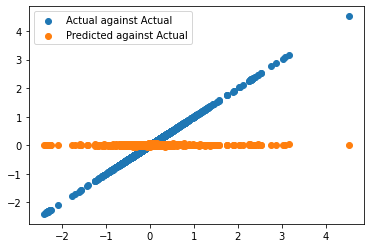

In [60]:
import matplotlib.pyplot as plt 

  
# plot lines 
plt.scatter(y_test, y_test, label = "Actual against Actual") 
plt.scatter(y_test, y_pred, label = "Predicted against Actual") 
plt.legend() 
plt.show()